In [ ]:
from elastic_nerf.utils import wandb_utils as wu
from pathlib import Path
import pandas as pd
from IPython.display import display
from collections import defaultdict
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import asdict
import torch
from tqdm import tqdm as tqdm
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize, BoundaryNorm
from matplotlib import colormaps as colormaps
from matplotlib.colors import ListedColormap


class ColorConfig:
    def __init__(self):
        self.set3_cmap = plt.get_cmap("Set2")
        self.colors = [self.set3_cmap(i) for i in range(7)]
        self.cmap = ListedColormap(self.colors)
        self.buckets = np.array([0, 1, 2, 4, 8, 16, 32, 64])
        self.norm = BoundaryNorm(self.buckets, len(self.buckets))

    def get_color(self, width):
        return self.cmap(self.norm(width))

    def get_colorbar(self, ax):
        cb = plt.colorbar(
            cm.ScalarMappable(cmap=self.cmap, norm=self.norm),
            ticks=self.buckets,
            format="%.0f",
            ax=ax,
        )
        cb.ax.minorticks_off()
        return cb


sweep_mappings = {
    # "2uxektzo": "ngp_occ-mipnerf360-baseline",
    # "kebumdc0": "ngp_occ-mipnerf360-baseline",
    # "xxjsfkbw": "ngp_prop-mipnerf360-baseline",
    # "8w0wks0x": "ngp_prop-mipnerf360-baseline",
    # "qfkjdvv2": "ngp_occ-mipnerf360-sampling_single",
    # "hy03dx0e": "ngp_occ-mipnerf360-sampling",
    # "wsxh6gjo": "ngp_prop-mipnerf360-sampling",
    # "8ishbvau": "ngp_prop-mipnerf360-sampling_single",
    # "b674pjcs": "ngp_occ-mipnerf360-baseline_head_depth1",
    # "58hgroe5": "ngp_prop-mipnerf360-baseline_head_depth1",
    # "c6g1mc5g": "ngp_occ-mipnerf360-baseline-mup",
    # "ccrwhsr5": "ngp_prop-mipnerf360-baseline-mup",
    # "2gc9i1ze": "ngp_prop-mipnerf360-baseline-granular_norm",
    # "uvhc38k5": "ngp_prop-mipnerf360-sampling-mup-norm",
    # "misquy10": "ngp_prop-mipnerf360-baseline-mup-norm-he_init_normalized",
    # "m5qq3rwy": "ngp_prop-mipnerf360-baseline-mup-he_init_normalized",
    "rhkqeuzo": "ngp_prop-mipnerf360-sampling-mup-he_init_normalized"
}

NB_NAME="tr1j_mup_sampling_he_init_normalized"

# [WARNING: BUGGY] ~~TR1j_mUP_Sampling_He_Init_Normalized~~
We had a bug where we never did the He initialization/spectral normalization on the radiance field weights. This is why those weights aren't all together in the beginning

~~Similar to `tr1h` but this time (like in `tr1i`), we disable GranularNorm and see how it performs with just applying spectral normalization to the initial weights after He init while doing joint sampling and 1x sampling on the counter scene with head depth 1~~

## TAKEAWAYS:


In [ ]:
tables = ["EvalResultsSummarytable"]
sweeps = sweep_mappings.keys()
results_cache_dir = Path("/home/user/shared/results/elastic-nerf")
sweep_results = {}

for sweep in sweeps:
    sweep_results[sweep] = wu.fetch_sweep_results(
        sweep=sweep,
        refresh_sweep_cache=False,
        refresh_run_cache=False,
        download_history=True,
        tables=tables,
    )
all_history = []
# Create a dataframe with all the results
for sweep_name in sweep_results:
    for run in sweep_results[sweep_name]:
        # Flatten the config
        flat_config = wu.flatten_dict(run.config, sep="-")
        # Concatenate the config with each row of the history results
        # Note that history results are already a dataframe
        history = run.history
        history["sweep_id"] = sweep_name
        history["run_id"] = run.run_id
        history["model_type"] = (
            "Nerfacc Prop" if "prop" in sweep_mappings[sweep_name] else "Nerfacc Occ"
        )
        history["sweep_name"] = sweep_mappings[sweep_name]
        for key in flat_config:
            try:
                history[key] = str(flat_config[key])
            except:
                print(f"Failed to add {key} to history with value {flat_config[key]}")
                raise
        all_history.append(history)

# %%
# Concatenate all the history results into a single dataframe
final_df = pd.concat(all_history, ignore_index=True)


# %%

fp = f"results_{NB_NAME}.csv"
final_df.to_csv(fp, index=False)
print(f"Saved results to {fp}")
df = pd.read_csv(fp)

(gonas) [WARNING] Loading cached results for sweep rhkqeuzo


Saved results to results_tr1j_mup_sampling_he_init_normalized.csv


/tmp/ipykernel_262670/3360067825.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[key] = str(flat_config[key])
/tmp/ipykernel_262670/3360067825.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  history[key] = str(flat_config[key])
/tmp/ipykernel_262670/3360067825.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, u

# Results
## Sampling Strategy
First, let's take a look at the average results across 3 random seeds. Why are the results for Stump so awful all the time??

In [ ]:
num_scenes = len(df["scene"].unique())
table_cols = ["Scene", "Head Depth", "Num Sampled Widths", "Width 64", "Width 32", "Width 16", "Width 8"]
elastic_widths = [8, 16, 32, 64]
base_psnrs = {scene.lower(): psnr for (psnr, scene) in zip([23.23,25.42,25.24,30.71,26.74,30.70,30.99], ['Bicycle','Garden','Stump','Bonsai','Counter', 'Kitchen', 'Room'])}

for i, (model_type, model_group) in enumerate(df.groupby(by="model_type")):
    model_group = model_group.query("_step == 20000")
    for k, (head_depth, head_depth_group) in enumerate(
        model_group.groupby(by="radiance_field-head_depth")
    ):
        table_data = []
        for j, (scene, scene_group) in enumerate(head_depth_group.groupby(by="scene")):
            # base_psnr = model_group.query(
            #     "_step == 20000 and hidden_dim == 64 and scene == @scene and `radiance_field-head_depth` == 2"
            # )["Eval Results Summary/psnr_avg/elastic_64"].median()
            base_psnr = base_psnrs[scene]
            for num_widths_to_sample, num_widths_to_sample_group in scene_group.groupby(by="num_widths_to_sample"):
                table_row = {"Scene": scene.capitalize(), "Head Depth": f"{head_depth}", "Num Sampled Widths": f"{num_widths_to_sample}"}
                for dim in elastic_widths:
                    psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
                    psnr_avg = num_widths_to_sample_group[psnr_col].median()
                    psnr_std = num_widths_to_sample_group[psnr_col].std()
                    pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
                    table_row.update(
                        {
                            f"Width {dim}": f"{psnr_avg:.2f}±{psnr_std:.2f} ({pc_diff:.2f}%)"
                        }
                    )
                table_data.append(table_row)

        table_data = pd.DataFrame(table_data, columns=table_cols)
        caption = (
            f"PSNR values after 20k steps of training for {model_type} model (with Radiance Field head MLP depth = {head_depth}) at different widths across scenes from the MipNeRF-360 dataset."
            f"  Values in brackets are the percentage difference compared to the baseline PSNR for each model at full-size (width 64) and Radiance Field Head MLP depth 2 (default model)."
        )
        table_data = table_data.style.set_caption(caption)
        display(table_data)
    # print(
    #     table_data.to_latex(
    #         index=False,
    #         caption=f"Baseline performance (PSNR) after 20k steps of training for {model_type_name} model at different widths across scenes from the MipNeRF-360 dataset",
    #         label=f"tab:baseline_{model_type_name.replace(' ', '_')}",
    #         position="h",
    #         column_format="lcccccc",
    #         escape=True,
    #         bold_rows=True,
    #     )
    # )

# LaTeX table for Head Depth 2 (Skip because we didn't measure Nerfacc Occ)

In [ ]:
# num_scenes = len(df["scene"].unique())
# table_cols = ["Scene", "Width 64", "Width 32", "Width 16", "Width 8"]

# header_row1 = [
#     "\multicolumn{4}{c}{NGP Occ} & \\multicolumn{4}{c}{NGP Prop} \\\\",
# ]
# header_row2 = [
#     "\\textbf{Scene}",
#     "Width 64",
#     "Width 32",
#     "Width 16",
#     "Width 8",
#     "Width 64",
#     "Width 32",
#     "Width 16",
#     "Width 8",
# ]
# header = (
#     " & ".join(header_row1)
#     + " \\midrule \n"
#     + " & ".join(header_row2)
#     + " \\\\ \\midrule"
# )

# table_data = []

# base_psnrs = defaultdict(dict)
# for j, (scene, scene_group) in enumerate(df.groupby(by="scene")):
#     table_row = ["\\textbf{" + scene.capitalize() + "}"]  # Scene names in bold
#     for i, (model_type, model_group) in enumerate(scene_group.groupby(by="model_type")):
#         model_group = model_group.query("_step == 20000")
#         model_group = model_group[model_group["radiance_field-head_depth"] == 2]
#         # base_psnr = model_group.query("hidden_dim == 64")[
#         #     "Eval Results Summary/psnr_avg/elastic_64"
#         # ].mean()
#         base_psnrs[scene][model_type] = base_psnr
#         for dim in [64, 32, 16, 8]:
#             dim_group = model_group.query(f"hidden_dim == {dim}")
#             psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
#             psnr_avg = dim_group[psnr_col].mean()
#             psnr_std = dim_group[psnr_col].std()
#             pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
#             if dim == 64:
#                 table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f}")
#             else:
#                 table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f} ({pc_diff:.1f}\\%)")
#     table_data.append(table_row)

# # Converting the Python list of lists to a LaTeX table
# table_body = " \\\\\n".join([" & ".join(row) for row in table_data]) + " \\\\"

# # Combining the header and body to form the final table
# final_table = (
#     "\\begin{table*}[h]\n\\centering\n\\small\n"
#     "\\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 2 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}\n"
#     "\\label{tab:combined_baseline_NGP}\n"
#     "\\begin{tabular}{lcccc|cccc}\n\\toprule\n"
#     + header
#     + "\n"
#     + table_body
#     + "\n\\bottomrule\n"
#     "\\end{tabular}\n\\end{table*}"
# )
# print(final_table)

# LaTeX table for Head Depth 1 (Skip because we didn't measure Nerfacc Occ)

In [ ]:
# num_scenes = len(df["scene"].unique())
# table_cols = ["Scene", "Width 64", "Width 32", "Width 16", "Width 8"]

# header_row1 = [
#     "\multicolumn{4}{c}{NGP Occ} & \\multicolumn{4}{c}{NGP Prop} \\\\",
# ]
# header_row2 = [
#     "\\textbf{Scene}",
#     "Width 64",
#     "Width 32",
#     "Width 16",
#     "Width 8",
#     "Width 64",
#     "Width 32",
#     "Width 16",
#     "Width 8",
# ]
# header = (
#     " & ".join(header_row1)
#     + " \\midrule \n"
#     + " & ".join(header_row2)
#     + " \\\\ \\midrule"
# )

# table_data = []

# base_psnrs = defaultdict(dict)
# for j, (scene, scene_group) in enumerate(df.groupby(by="scene")):
#     table_row = ["\\textbf{" + scene.capitalize() + "}"]  # Scene names in bold
#     for i, (model_type, model_group) in enumerate(scene_group.groupby(by="model_type")):
#         model_group = model_group.query("_step == 20000")
#         model_group = model_group[model_group["radiance_field-head_depth"] == 1]
#         base_psnr = model_group.query("hidden_dim == 64")[
#             "Eval Results Summary/psnr_avg/elastic_64"
#         ].mean()
#         base_psnrs[scene][model_type] = base_psnr
#         for dim in [64, 32, 16, 8]:
#             dim_group = model_group.query(f"hidden_dim == {dim}")
#             psnr_col = f"Eval Results Summary/psnr_avg/elastic_{dim}"
#             psnr_avg = dim_group[psnr_col].mean()
#             psnr_std = dim_group[psnr_col].std()
#             pc_diff = 100 * (psnr_avg - base_psnr) / base_psnr
#             if dim == 64:
#                 table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f}")
#             else:
#                 table_row.append(f"{psnr_avg:.2f}±{psnr_std:.2f} ({pc_diff:.1f}\\%)")
#     table_data.append(table_row)

# # Converting the Python list of lists to a LaTeX table
# table_body = " \\\\\n".join([" & ".join(row) for row in table_data]) + " \\\\"

# # Combining the header and body to form the final table
# final_table = (
#     "\\begin{table*}[h]\n\\centering\n\\small\n"
#     "\\caption{Combined Baseline PSNR after 20k steps of training optimally with mUP for NGP Occ and NGP Prop models (with depth of 1 for the Radiance Field head MLP) at different widths across scenes from the MipNeRF-360 dataset}\n"
#     "\\label{tab:combined_baseline_NGP}\n"
#     "\\begin{tabular}{lcccc|cccc}\n\\toprule\n"
#     + header
#     + "\n"
#     + table_body
#     + "\n\\bottomrule\n"
#     "\\end{tabular}\n\\end{table*}"
# )
# print(final_table)

# Exploring the results from the perspective of Maximal Update Parameterization

Previously during our initial explorations into mUP, we arrived at the following conclusions for a simple MLP with 2 hidden layers:
### Layer 1
Init variance:
- Target variance is 0.5, target std is 0.7, actual variance approaches 0.5 as n→inf
- Standard xavier normal initialization has std which seems to scale as $\sqrt{\frac{2}{fanin + fanout}}$ 
	- So as fanout → inf (this is our width), std gets smaller and smaller
	- Instead, mup says that it should only scale as a function of `1/fan_in` (which for us scales O(1)) so we end up with a constant init var for input weight across all widths. **Thus we set target variance to 0.5**
	- Under the hood, mup multiplies the standard scale by $\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
		- $\therefore \sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
		- $\sqrt{\frac{2}{3 + fanout}} \cdot \sqrt{\frac{fanout + 3}{1 + 3}} = \sqrt{\frac{2}{4}} = \sqrt{0.5}$
		- $\therefore Var = \sigma^{2} = 0.5$
Multiplier:
- `fan_in.width_mult` scales constantly O(1)
- but the shape’s width_mult seems to scale linearly? _O(n)_?
Learning rate:
- LR scales constantly O(1) (**so same as global LR**) for **Adam**

### Layer 2 (Hidden Layer)
Init variance:
- Xavier initialization by default scales init variance scale as $\sqrt{\frac{2}{fanin + fanout}}$ 
- But mup first scales the usual std by $\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$
	- and then for weights with 2 infinite dimensions (i.e. hidden layer weights where both fanin and fanout are infinite), it additionally divides it by $\sqrt{faninWidthMult}$
	- $\therefore \sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}} / \sqrt{faninWidthMult}$
	- Note that in our case, we have a square matrix so `fanin.dim == fanout.dim == width`. Also `fan_in.width_mult() == width` since our base network was “pure” with `width==1`
	- $\therefore \sqrt{\frac{2}{width + width}} \cdot \sqrt{\frac{width + width}{1 + 1}} \cdot \frac{1}{\sqrt{faninWidthMult}} =  \frac{1}{\sqrt{faninWidthMult}}$
	- Note that this ends up being the same as the default initialization because $\sqrt{\frac{2}{fanin + fanout}} = \sqrt{\frac{1}{width}} = \sqrt{\frac{1}{faninWidthMult}}$ 
	- **This doesn’t match up with Table 8 which says for hidden weights, init variance scales `1/fan_in`?**

Multiplier:
- both `fan_in.width_mult()` and `width_mult` scale linearly O(n)? But then why does **Table 8 say the multiplier is 1?**

Learning Rate:
- We set the global learning rate to 0.1
- mup Adam scales the global lr by $\frac{1}{fanin}$ (or in the code, divides the `group['lr'] /= width_mult)
- This matches up with all the tables which say for hidden weights, scale the global LR by $lr = gLR \cdot \frac{1}{fanin}$ 

### Readout (Output Layer)
Init variance:
- Recall that mup scales the usual std by
  
$$\sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$$

Thus, we get:

$$\sqrt{\frac{2}{fanin + fanout}} \cdot \sqrt{\frac{fanout + fanin}{fanoutBase + faninBase}}$$
 
$$= \sqrt{\frac{2}{width + 16}} \cdot \sqrt{\frac{16 + width}{16 + 1}} = \sqrt{\frac{2}{fanout +1}} = \sqrt{\frac{2}{17}}$$
 
- This matches up with Table 

## Training Dynamics

Let's take a look at the training dynamics for the width 64 baseline models after training them with mUP. Specifically, we want to see if the spectral norm scaling stays constant as the width increases (as they claim it should).

In [ ]:
def make_df_for_run(
    weight_norms, grad_norms, config, model_type, steps, sweep_id, run_id
):
    results_all = []
    num_steps = 43
    num_widths = config.hidden_dim
    module_names = list(weight_norms.keys())
    flattened_config = wu.flatten_dict(asdict(config), sep=".")
    for step_idx in range(num_steps):
        base_width = 8
        for width_idx in range(num_widths):
            for module_name in module_names:
                try:
                    results = {
                        "step": steps[step_idx],
                        "width": width_idx + 1,
                        "module": module_name,
                        "sweep_id": sweep_id,
                        "run_id": run_id,
                        "model_type": model_type,
                    }
                    results.update(flattened_config)
                    for metric_type in [
                        "L1",
                        "Frobenius",
                        "Spectral (max)",
                        "Spectral (min)",
                    ]:
                        if (
                            len(weight_norms[module_name][metric_type]["1D"][step_idx])
                            < num_widths
                        ):
                            # If the module wasn't elastic, we don't compute the norms for it
                            weight = None
                            weight_scaled = None
                            print(
                                f"Weight norms for {module_name} at step {step_idx} are missing elements, found {len(weight_norms[module_name][metric_type]['1D'][step_idx])} but expected {num_widths}"
                            )
                        else:
                            weight = weight_norms[module_name][metric_type]["1D"][
                                step_idx
                            ][width_idx]
                            base_weight = weight_norms[module_name][metric_type]["1D"][
                                step_idx
                            ][base_width - 1]

                            weight_scaled = (
                                weight / base_weight if base_weight > 0 else None
                            )

                        if (
                            step_idx == 0
                            or len(
                                grad_norms[module_name][metric_type]["1D"][step_idx - 1]
                            )
                            < num_widths
                        ):
                            grad = None
                            grad_scaled = None
                        else:
                            grad = grad_norms[module_name][metric_type]["1D"][
                                step_idx - 1
                            ][width_idx]
                            grad_base = grad_norms[module_name][metric_type]["1D"][
                                step_idx - 1
                            ][base_width - 1]
                            grad_scaled = grad / grad_base if grad_base > 0 else None
                        results.update(
                            {
                                f"weight/{metric_type}": weight,
                                f"weight_scaled/{metric_type}": weight_scaled,
                                f"grad/{metric_type}": grad,
                                f"grad_scaled/{metric_type}": grad_scaled,
                            }
                        )
                    results_all.append(results)
                except Exception as e:
                    print(
                        f"Encountered error at step {step_idx}, width {width_idx}, metric {metric_type} for {module_name}: {e}"
                    )
                    raise e

    return pd.DataFrame(results_all)


log_dir = Path("/home/user/shared/results/elastic-nerf")
wandb_dir = Path("/home/user/shared/wandb_cache/elastic-nerf")
results_cache_dir = Path("/home/user/shared/results/elastic-nerf")

COMPUTE_TRAINING_DYNAMICS_DF = True
if COMPUTE_TRAINING_DYNAMICS_DF:
    dfs = []
    for sweep_id in sweep_mappings.keys():
        sweep = wu.fetch_sweep(sweep_id)
        for run in tqdm(sweep.runs):
            training_dynamics_path = (
                results_cache_dir / run.id / "weights_grads/training_dynamics.pt"
            )
            training_dynamics = torch.load(training_dynamics_path)
            weight_norms = training_dynamics["weight_norms"]
            grad_norms = training_dynamics["grad_norms"]
            steps = training_dynamics["training_steps"]
            config = training_dynamics["config"]
            model_type = training_dynamics["model_type"]
            try:
                df = make_df_for_run(
                    weight_norms,
                    grad_norms,
                    config,
                    model_type,
                    steps,
                    sweep_id,
                    run.id,
                )
                dfs.append(df)
            except Exception as e:
                print(f"Failed to process run {run.id} from sweep {sweep_id}: {e}")

    df = pd.concat(dfs)
    df.to_csv(f"{NB_NAME}_training_dynamics.csv", index=False)
    cols = [
        "seed",
        "step",
        "width",
        "module",
        "sampling_strategy",
        "loss_weight_strategy",
        "radiance_field.use_elastic",
        "radiance_field.use_elastic_head",
        "radiance_field.head_depth",
        "density_field.use_elastic",
        "num_widths_to_sample",
        "model_type",
        "num_train_widths",
        "duplicate_train_batch_across_widths",
        "run_id",
        "sweep_id",
        "dataset.scene",
        "hidden_dim",
        "adjust_lr_for_duplicate_train_batch",
        "max_steps",
        "num_eval_elastic_widths",
        "fused_eval",
        "host_machine",
        "weight/L1",
        "weight_scaled/L1",
        "grad/L1",
        "grad_scaled/L1",
        "weight/Frobenius",
        "weight_scaled/Frobenius",
        "grad/Frobenius",
        "grad_scaled/Frobenius",
        "weight/Spectral (max)",
        "weight_scaled/Spectral (max)",
        "grad/Spectral (max)",
        "grad_scaled/Spectral (max)",
        "weight/Spectral (min)",
        "weight_scaled/Spectral (min)",
        "grad/Spectral (min)",
        "grad_scaled/Spectral (min)",
    ]
    df[cols].to_csv(f"{NB_NAME}_training_dynamics_filtered.csv", index=False)
else:
    df = pd.read_csv(f"{NB_NAME}_training_dynamics_filtered.csv")

  0%|                                                                                                                                                                                | 0/6 [00:00<?, ?it/s]2024-04-04 05:59:19.693910: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 05:59:19.697291: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-04 05:59:19.740239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-04 05:59:20.529391: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|████████████████████████████████████████████████████████████████████

In [ ]:
for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for head_depth, head_depth_group in model_type_group.groupby(
            by="radiance_field.head_depth"
        ):
            for widths_to_sample, widths_to_sample_group in head_depth_group.groupby(
                by="num_widths_to_sample"
            ):
                for module, module_group in widths_to_sample_group.groupby(by="module"):
                    pass

As expected, **the scaled norms do not provide any useful information in this case, since we're scaling with respect to the base width (of 8) which was never explicitly optimized**. Instead, the scale ratios we expect should be obtained by comparing against the training dynamics of a baseline width 8 model (one with hidden dim 8, not just one where we splice a layer width of 8). However, note that between different seeds, the width 64 training dynamics are somewhat consistent in shape. I think it would be useful to visualize just the width 64 norm across steps. Basically in each plot, we want to see the width 64 metric for all 3 seeds, each subplot should show a different metric, and each subfigure should show a different module.

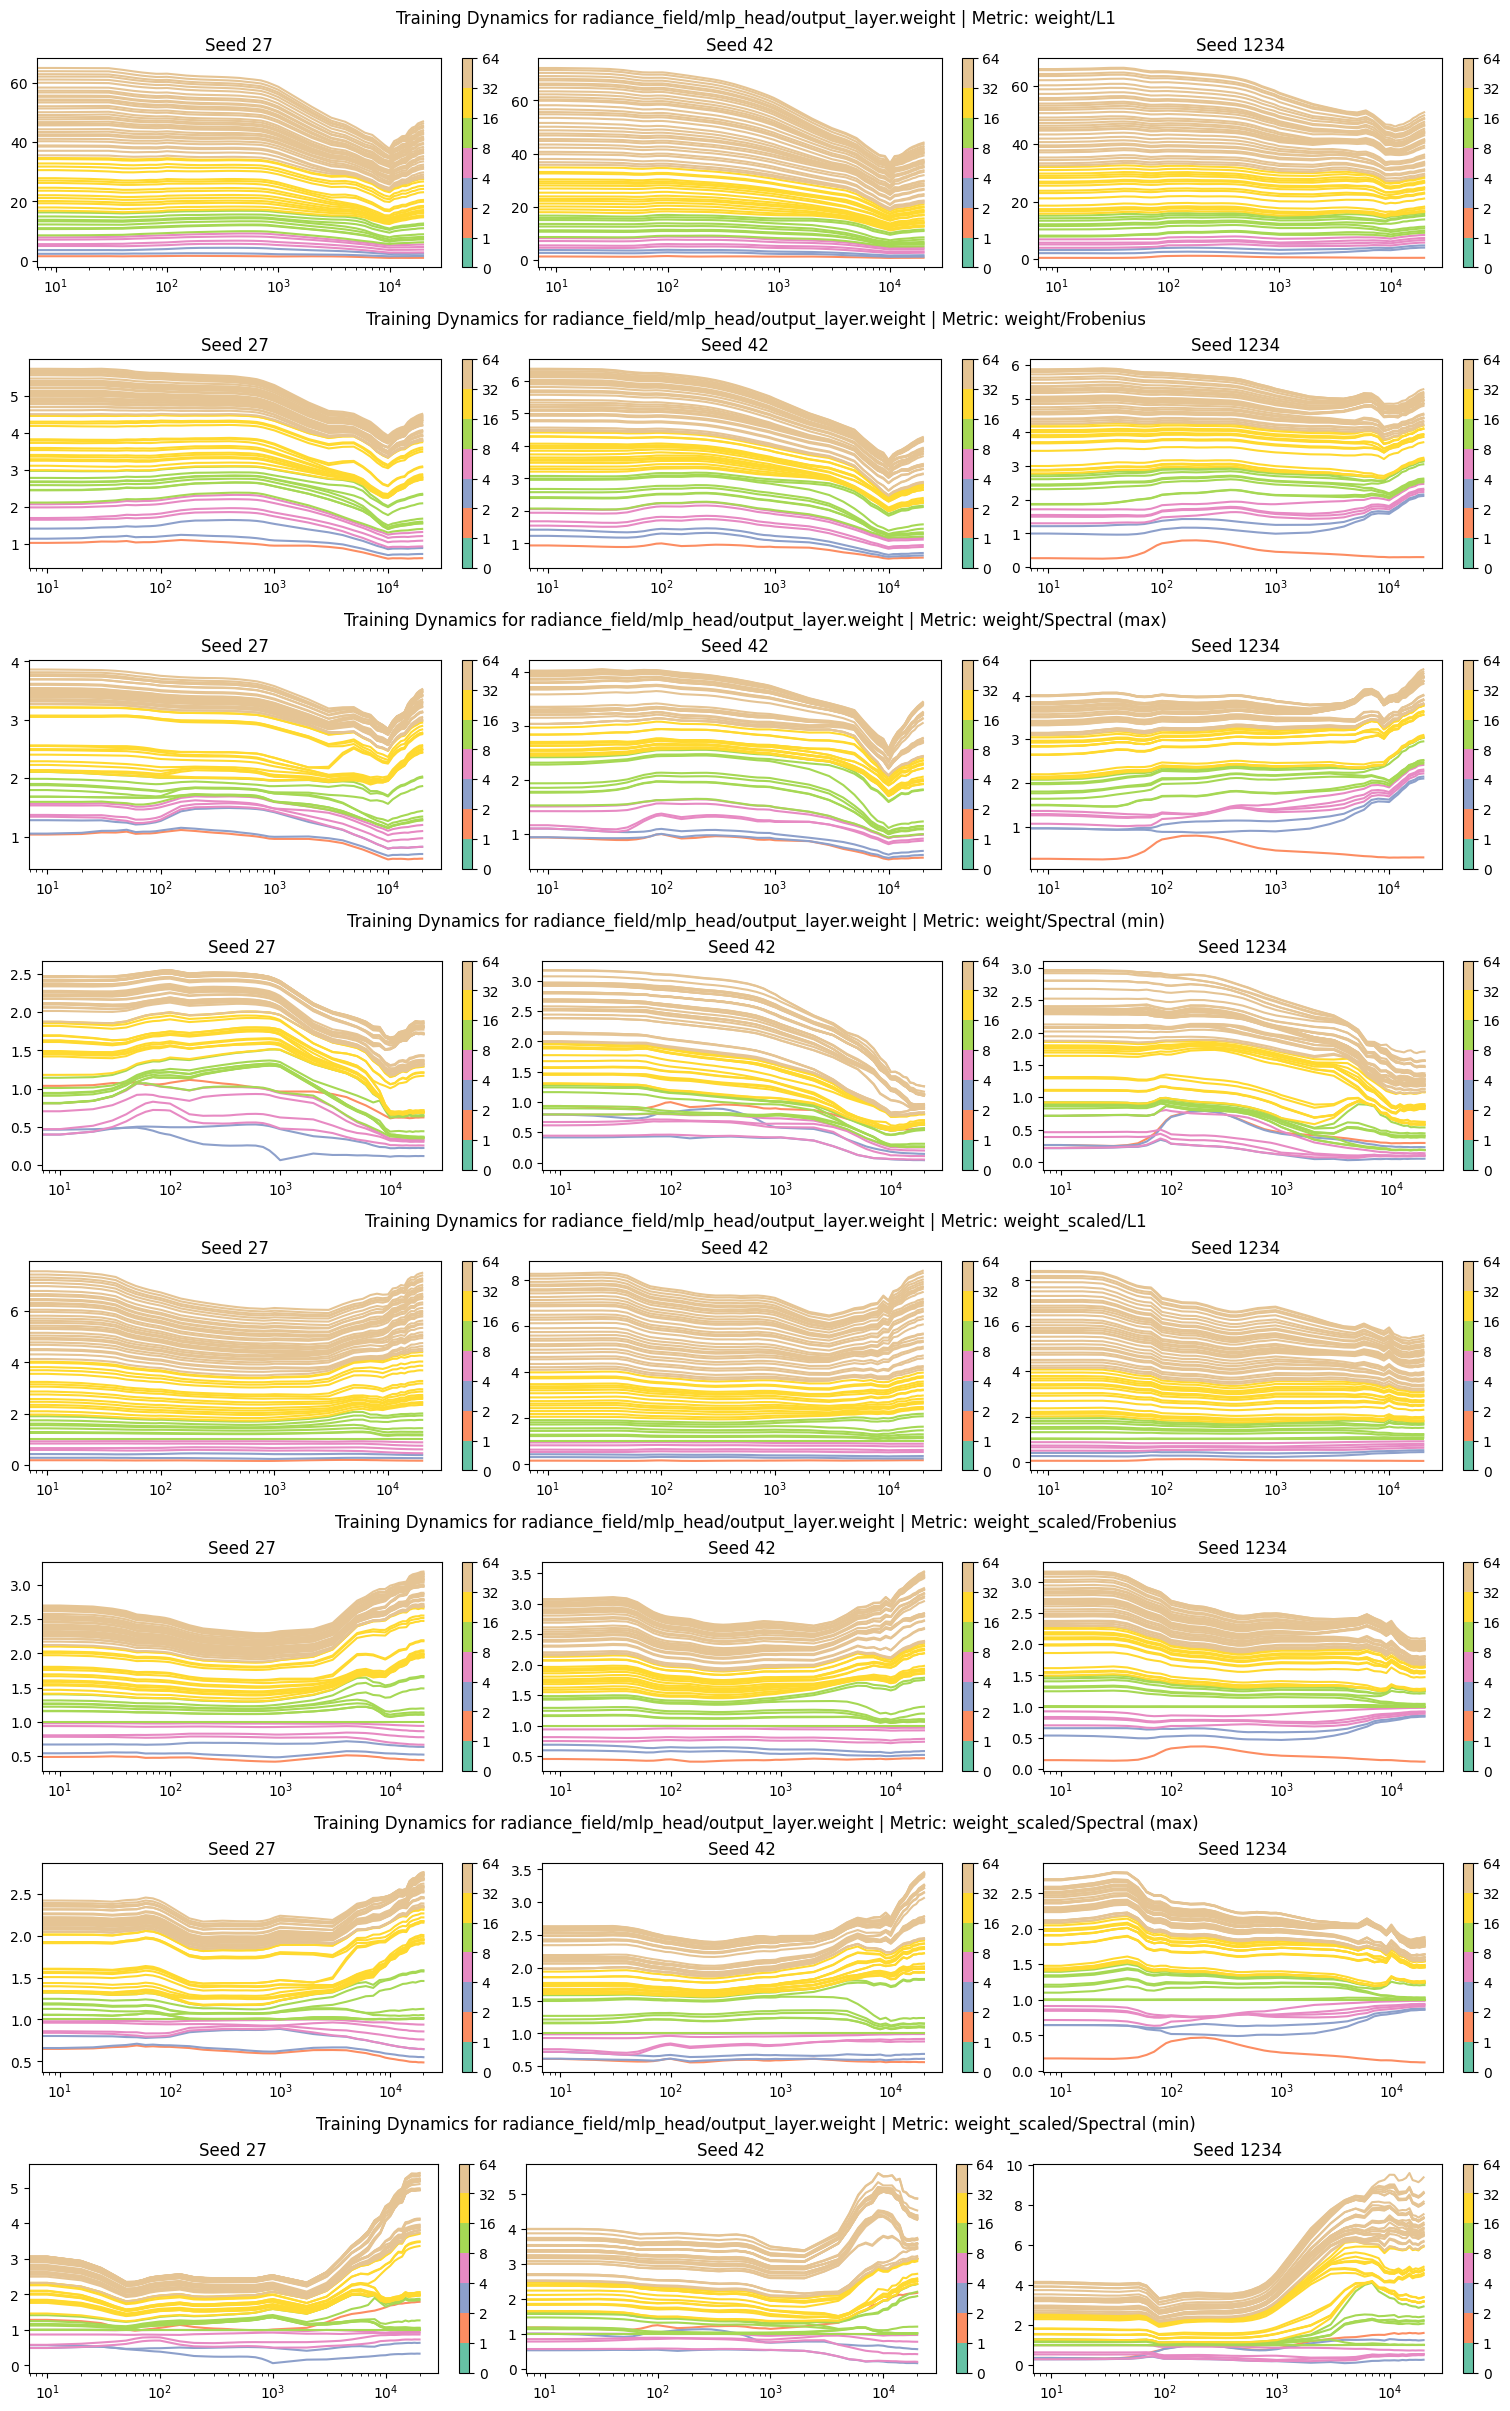

In [ ]:
cc = ColorConfig()
metric_types = [
    "weight/L1",
    "weight/Frobenius",
    "weight/Spectral (max)",
    "weight/Spectral (min)",
    "weight_scaled/L1",
    "weight_scaled/Frobenius",
    "weight_scaled/Spectral (max)",
    "weight_scaled/Spectral (min)",
]
fig = plt.figure(layout="constrained", figsize=(15, 3 * len(metric_types)))
subfigs = fig.subfigures(len(metric_types), 1, wspace=0.07)
for i, metric_type in enumerate(metric_types):
    subfig = subfigs[i]
    subfig.suptitle(f"Training Dynamics for {module} | Metric: {metric_type}")
    subplots = subfig.subplots(1, len(module_group["seed"].unique()))
    for j, (seed, seed_group) in enumerate(module_group.groupby(by="seed")):
        ax = subplots[j]
        for width, width_group in seed_group.groupby(by="width"):
            color = cc.get_color(width)
            ax.plot(width_group["step"], width_group[f"{metric_type}"], color=color)
        ax.set_xscale("log")
        ax.set_title(f"Seed {seed}")
        cc.get_colorbar(ax)

# Plot Weight Norms
Now let's take a look at the raw weight norms for a single scene (**Counter**)

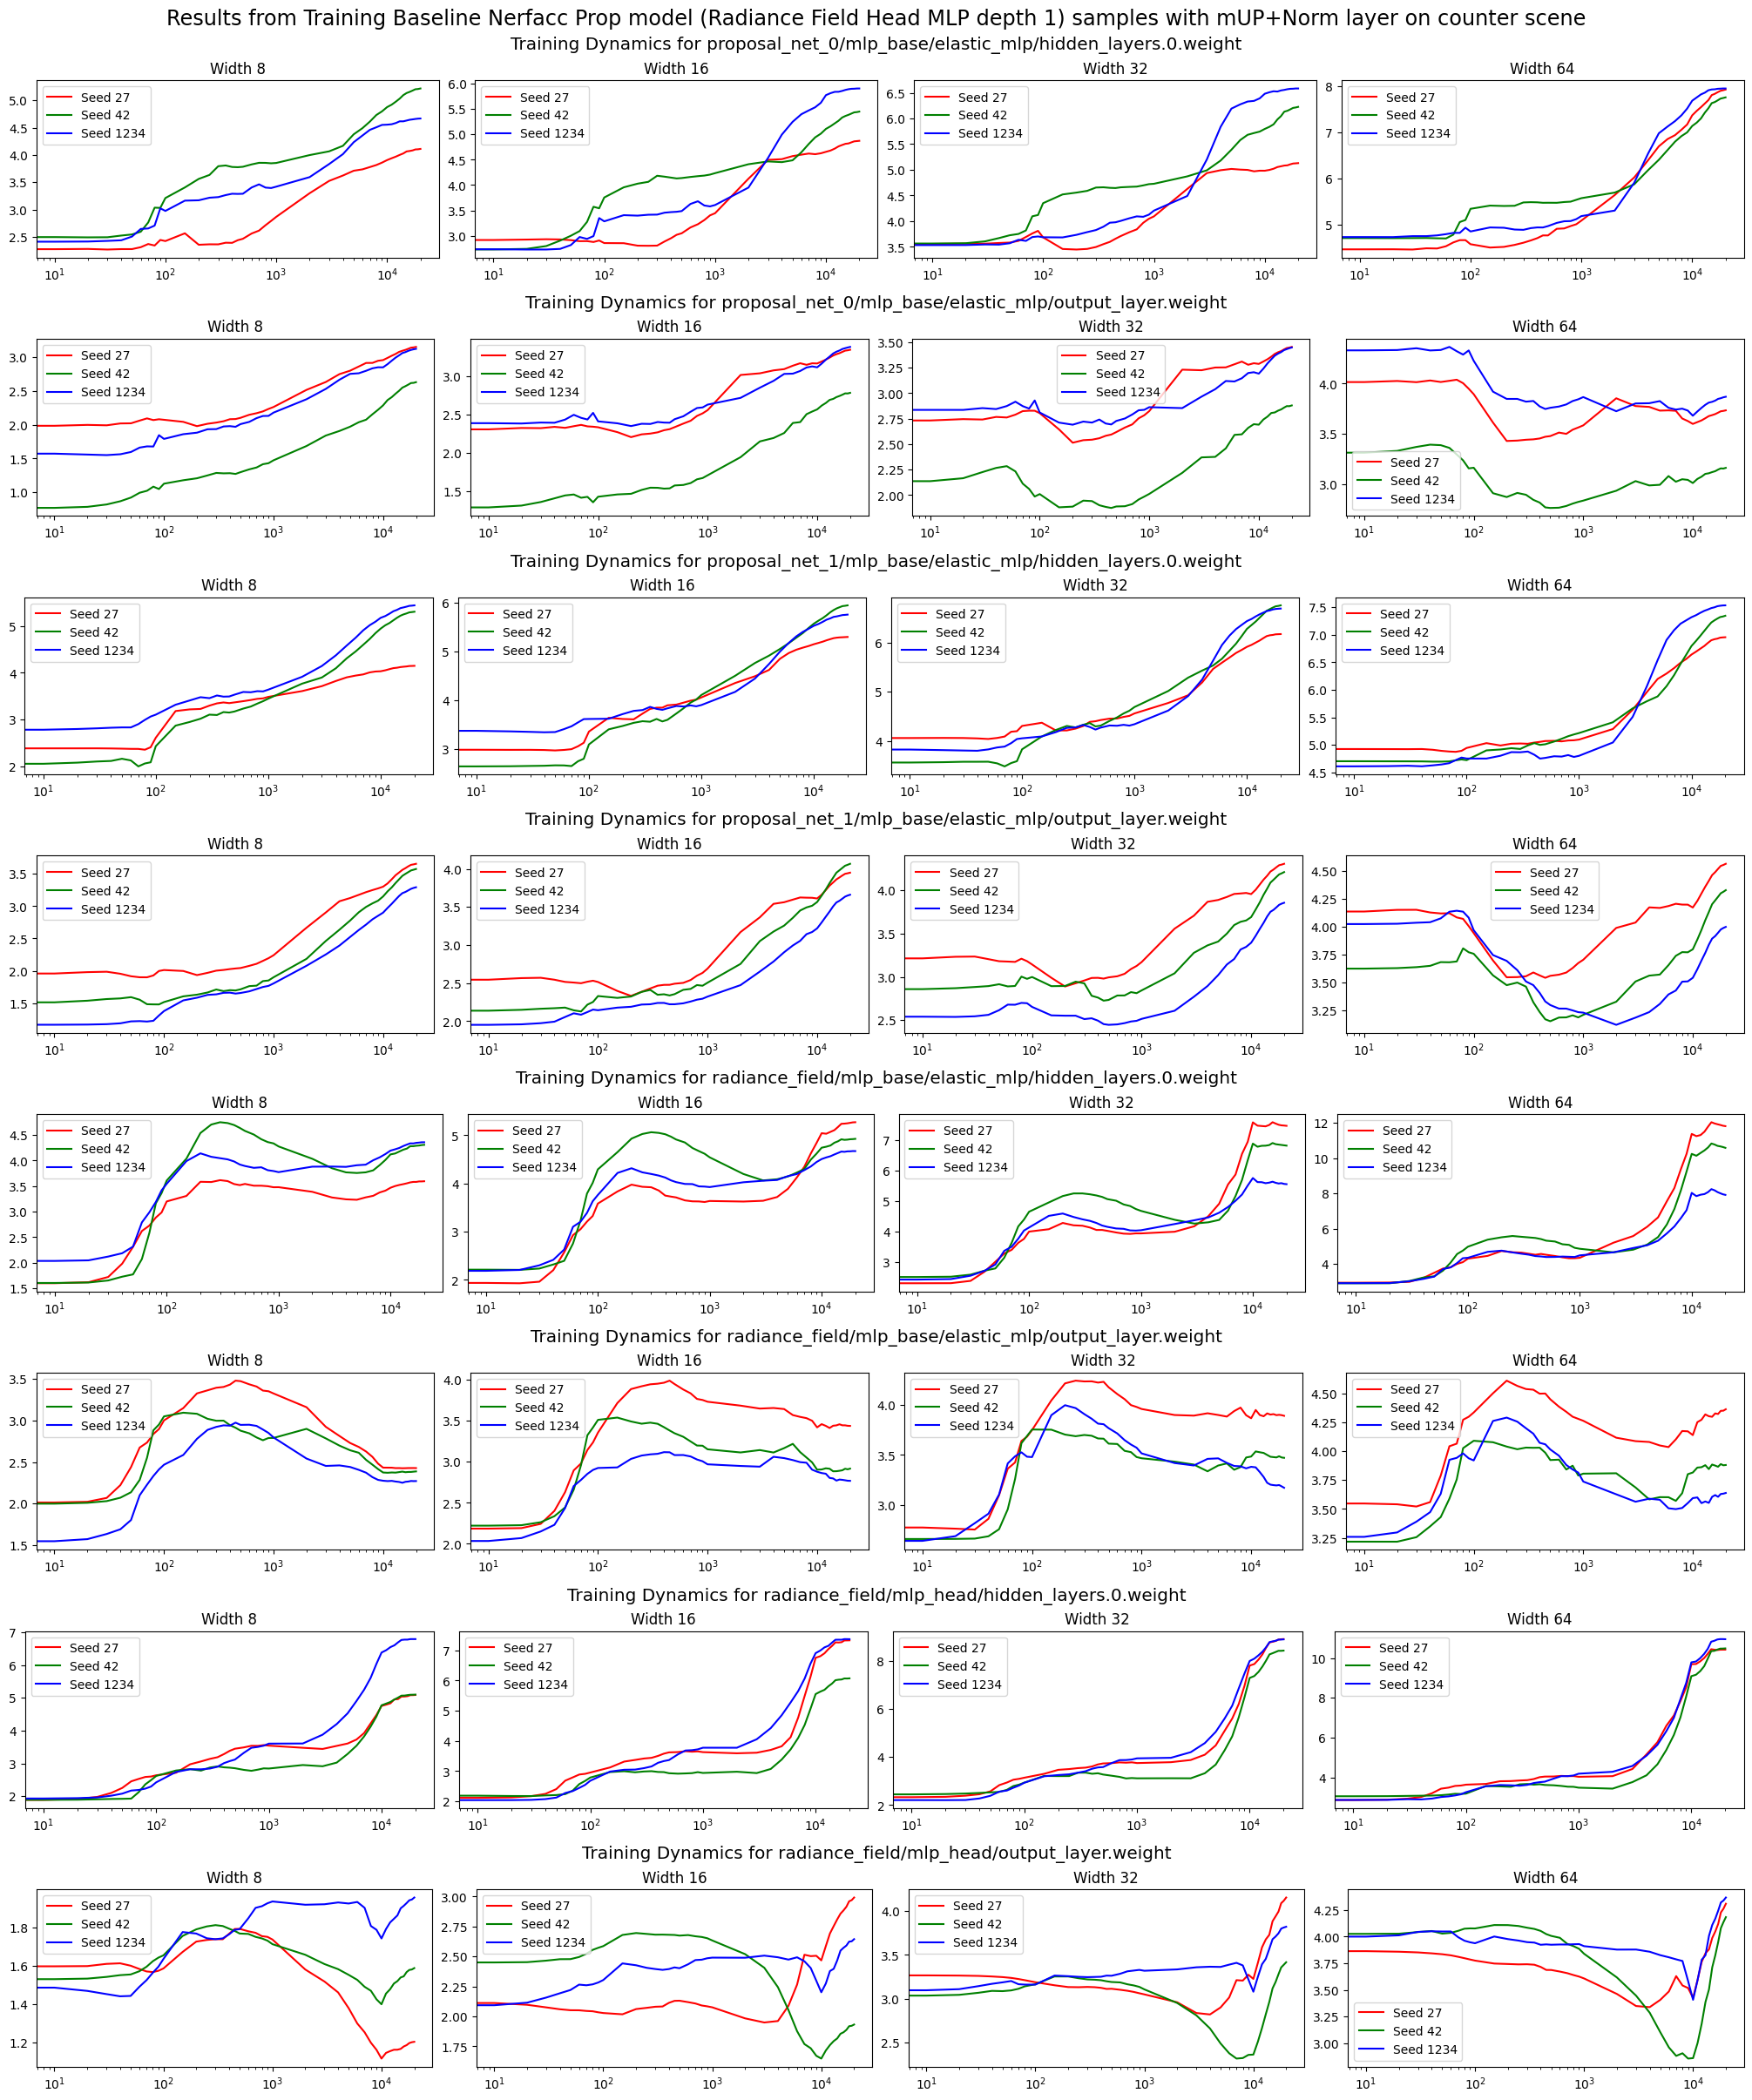

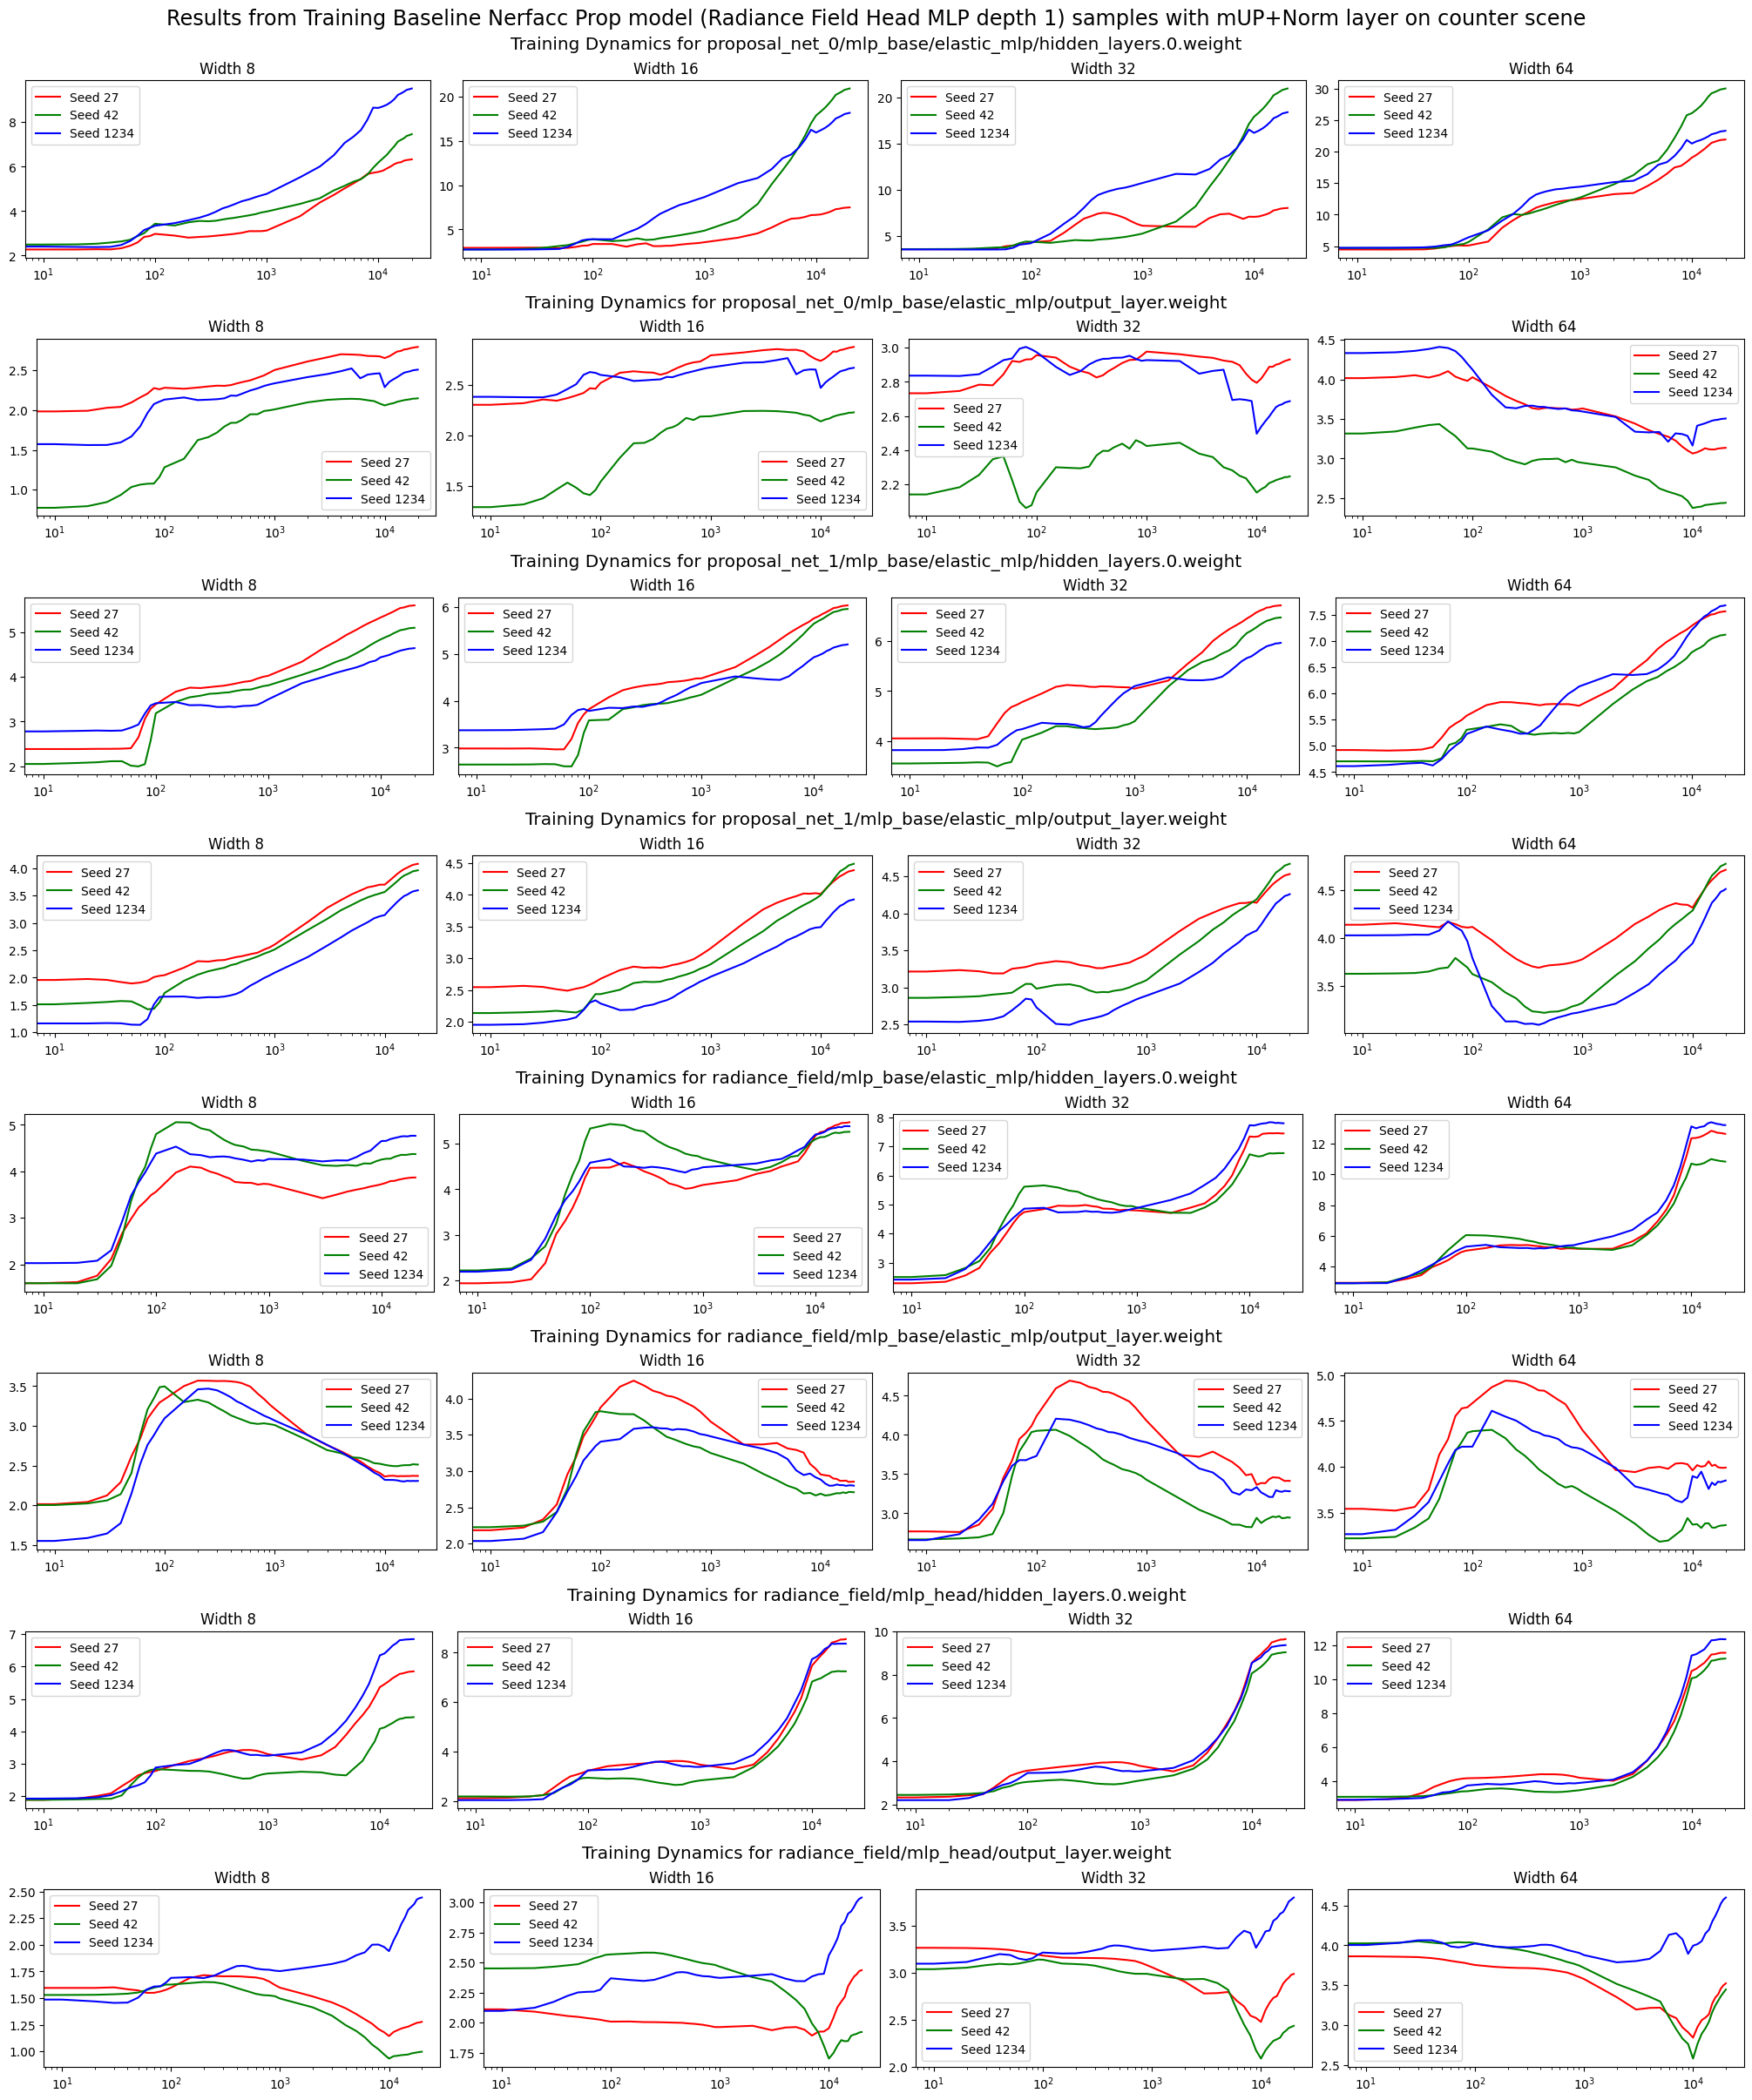

In [ ]:
metric_type = "weight/Spectral (max)"
elastic_widths = [8,16,32,64]
for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for widths_to_sample, widths_to_sample_group in model_type_group.groupby(
                by="num_widths_to_sample"
            ):
            for head_depth, head_depth_group in widths_to_sample_group.groupby(
                by="radiance_field.head_depth"
            ):
                fig = plt.figure(
                    layout="constrained",
                    figsize=(
                        5 * len(elastic_widths),
                        3 * len(head_depth_group["module"].unique()),
                    ),
                )
                model_type_name = (
                    "Nerfacc Occ" if "occ" in model_type else "Nerfacc Prop"
                )
                fig.suptitle(
                    f"Results from Training Baseline {model_type_name} model (Radiance Field Head MLP depth {head_depth}) samples with mUP+Norm layer on {scene} scene",
                    fontsize="xx-large",
                )
                colors = ["r", "g", "b"]
                subfigs = fig.subfigures(
                    len(head_depth_group["module"].unique()), 1, wspace=0.07
                )
                for i, (module, module_group) in enumerate(
                    head_depth_group.groupby(by="module")
                ):
                    subfig = subfigs[i]
                    subfig.suptitle(
                        f"Training Dynamics for {module}", fontsize="x-large"
                    )
                    subplots = subfig.subplots(1, len(elastic_widths))
                    for j, elastic_width in enumerate(elastic_widths):
                        ax = subplots[j]
                        for k, (seed, seed_group) in enumerate(
                            module_group.query('width == @elastic_width').groupby(by="seed")
                        ):
                            ax.plot(
                                width_group["step"],
                                seed_group[f"{metric_type}"],
                                color=colors[k],
                                label=f"Seed {seed}",
                            )
                        ax.set_xscale("log")
                        ax.set_title(f"Width {elastic_width}")
                        ax.legend()
                fig.show()
    # Only plot 1 scene
    break

In [ ]:
for hidden_dim, hidden_dim_group in model_type_group.groupby(by="hidden_dim"):
    for head_depth, head_depth_group in hidden_dim_group.groupby(
        by="radiance_field.head_depth"
    ):
        for i, (module, module_group) in enumerate(
            head_depth_group.query("width == @hidden_dim").groupby(by="module")
        ):
            break
        break
    break

In [ ]:
len(seed_group)

43

# Plot Weight scaling

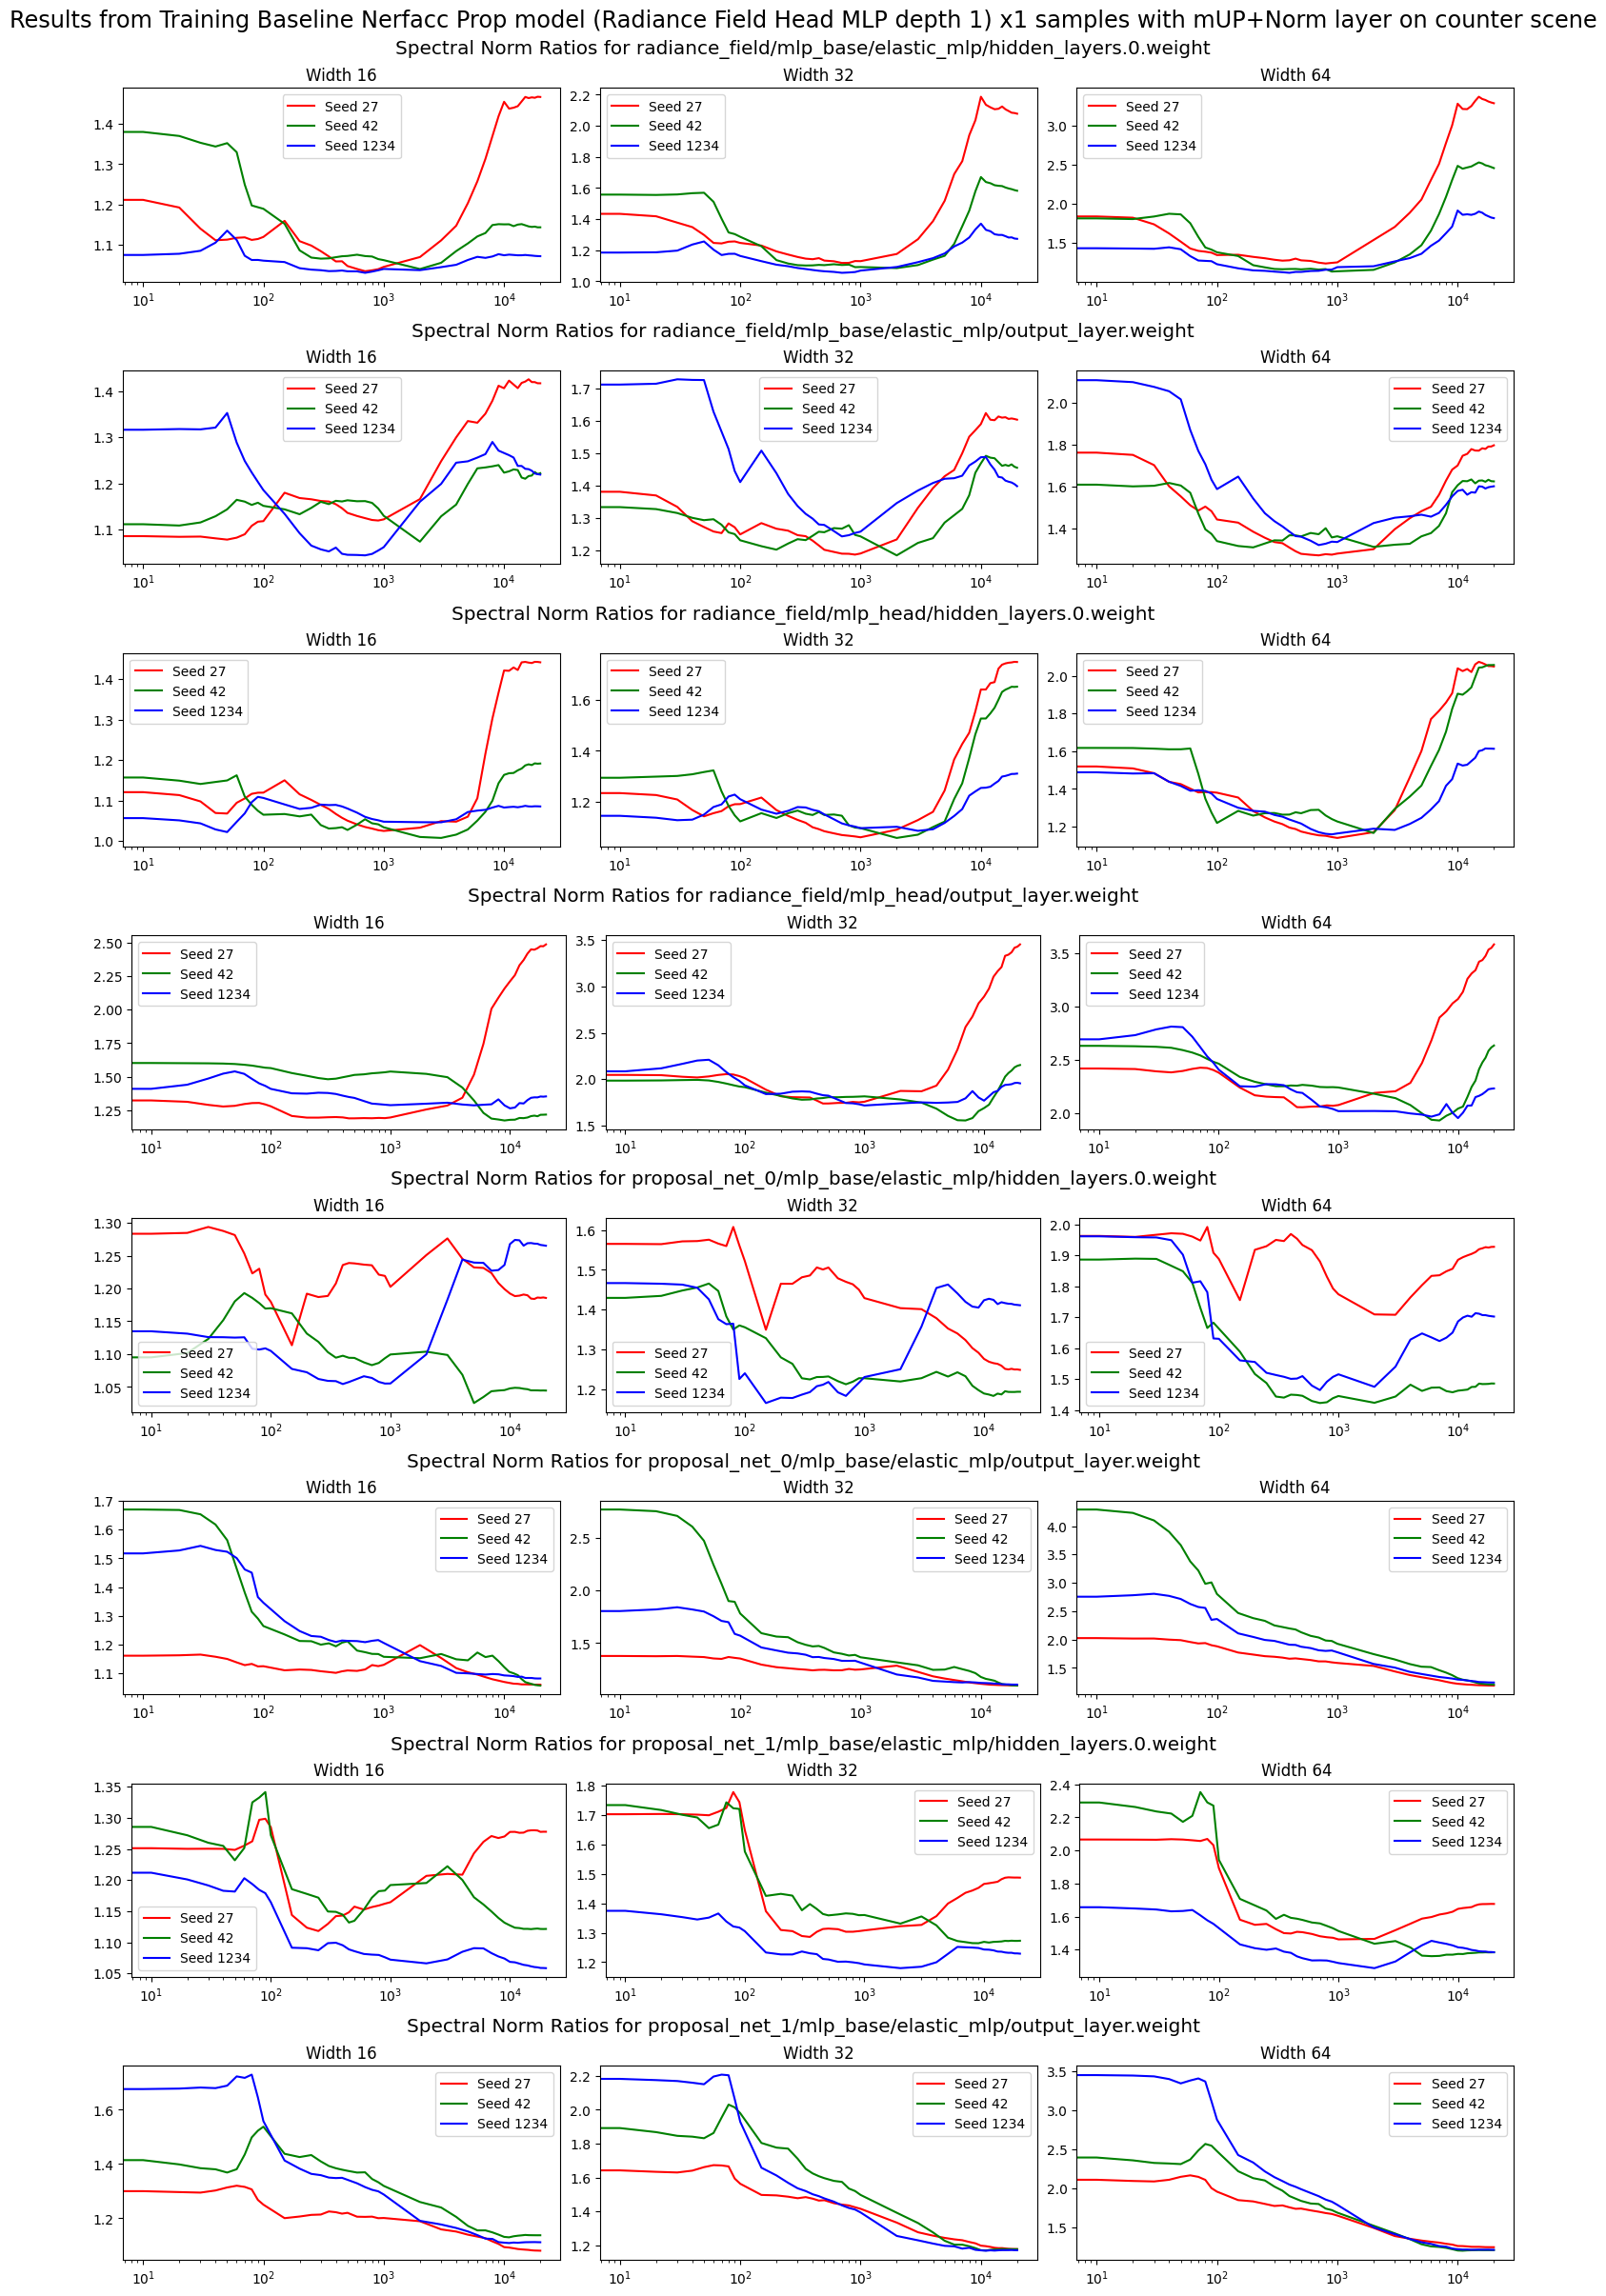

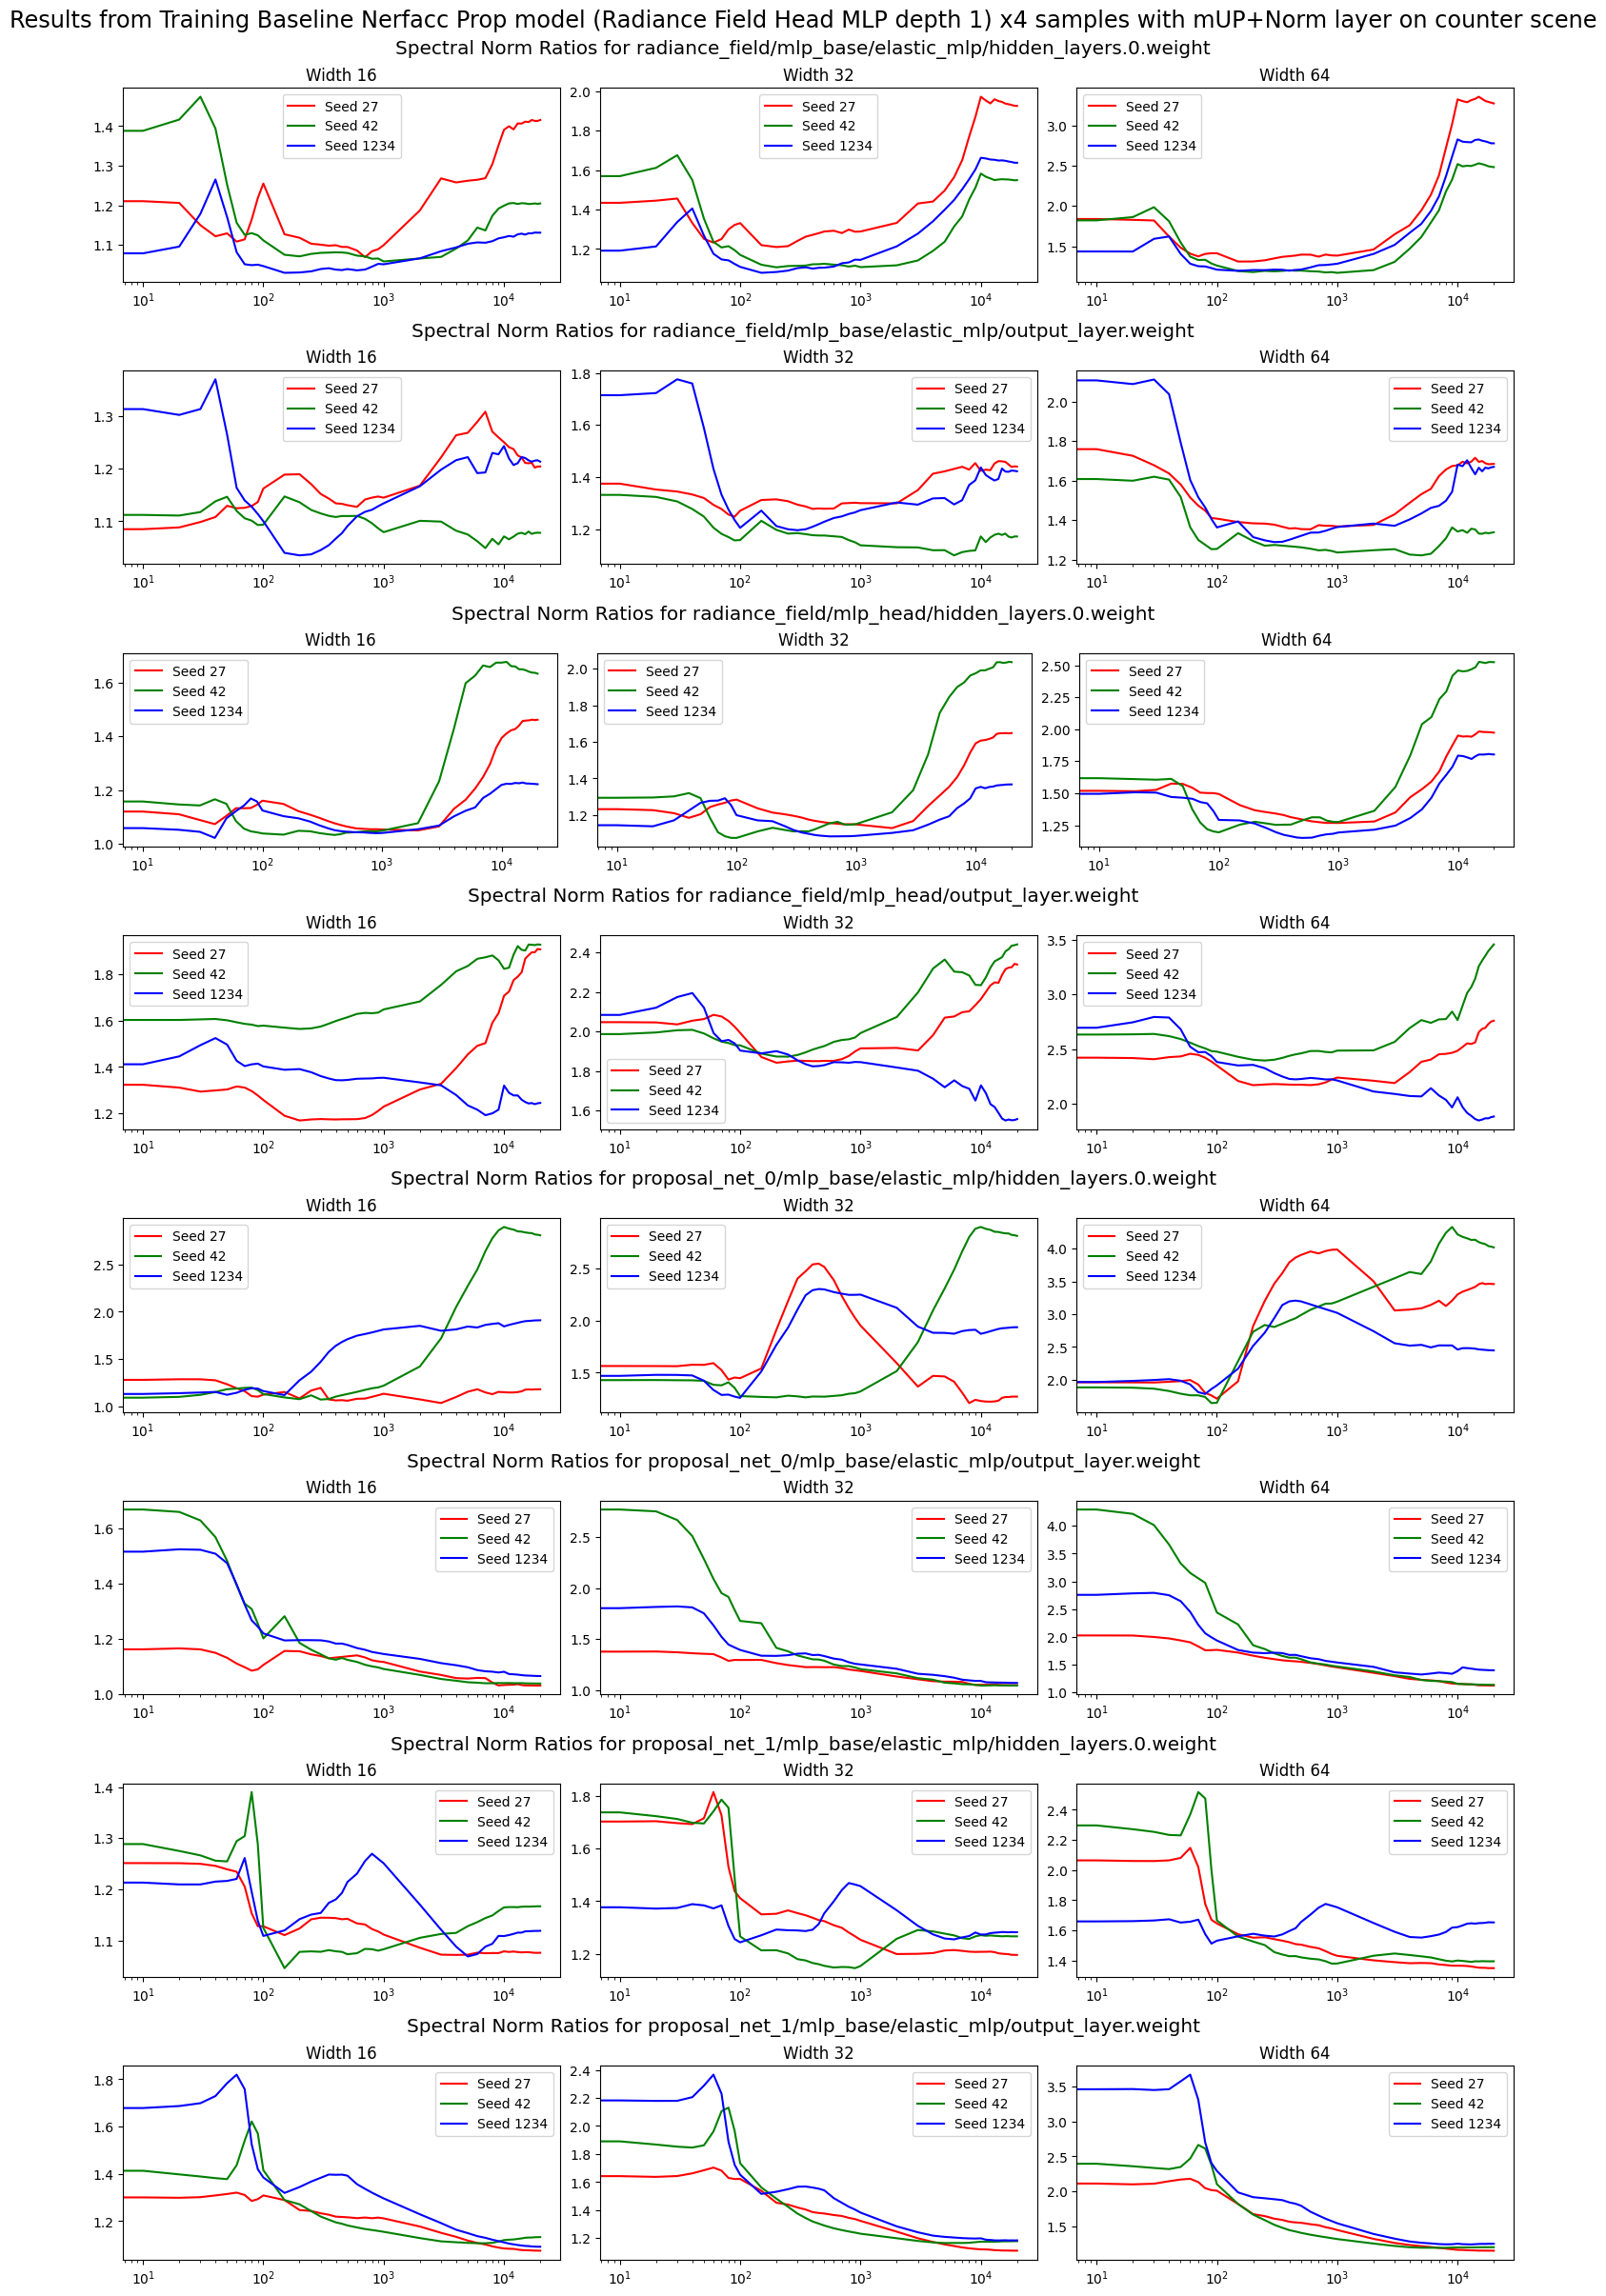

In [ ]:
metric_type = "weight/Spectral (max)"
elastic_widths = [8,16,32,64]

for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for widths_to_sample, widths_to_sample_group in model_type_group.groupby(
                by="num_widths_to_sample"
            ):
            for head_depth, head_depth_group in widths_to_sample_group.groupby(
                by="radiance_field.head_depth"
            ):
                num_modules = 0
                filtered_modules = []
                for m in head_depth_group["module"].unique():
                    if 'norm' not in m:
                        filtered_modules.append(m)
                        num_modules += 1
                fig = plt.figure(
                    layout="constrained",
                    figsize=(
                        5 * (len(elastic_widths)-1),
                        3 * num_modules,
                    ),
                )
                model_type_name = (
                    "Nerfacc Occ" if "occ" in model_type else "Nerfacc Prop"
                )
                fig.suptitle(
                    f"Results from Training Baseline {model_type_name} model (Radiance Field Head MLP depth {head_depth}) x{widths_to_sample} samples with mUP+Norm layer on {scene} scene",
                    fontsize="xx-large",
                )
                colors = ["r", "g", "b"]
                subfigs = fig.subfigures(
                    num_modules, 1, wspace=0.07
                )
                for i, module in enumerate(filtered_modules):
                    module_group = head_depth_group.query('module == @module')
                    subfig = subfigs[i]
                    subfig.suptitle(
                        f"Spectral Norm Ratios for {module}", fontsize="x-large"
                    )
                    subplots = subfig.subplots(1, len(elastic_widths)-1)
                    for j, elastic_width in enumerate(elastic_widths):
                        if elastic_width == 8:
                            # Skip width 8 since we're plotting the ratio wrt it (so it'll be constant).
                            continue
                        ax = subplots[j-1]
                        base_psnrs = module_group.query("width == 8")
                        for k, (seed, seed_group) in enumerate(
                            module_group.query('width == @elastic_width').groupby(by="seed")
                        ):
                            base_psnrs_over_steps = base_psnrs.query('seed == @seed')
                            assert(len(base_psnrs_over_steps) == len(seed_group))
                            assert(len(seed_group) != 0)
                            with np.errstate(divide='ignore',invalid='ignore'):
                                out = np.divide(
                                        seed_group[f"{metric_type}"].to_numpy(),
                                        base_psnrs_over_steps[f"{metric_type}"].to_numpy(),
                                    )
                            ax.plot(
                                width_group["step"],
                                out,
                                color=colors[k],
                                label=f"Seed {seed}",
                            )
                        ax.set_xscale("log")
                        ax.set_title(f"Width {elastic_width}")
                        ax.legend()
                fig.show()
    # Only plot 1 scene
    break

# Plot Grad Scaling

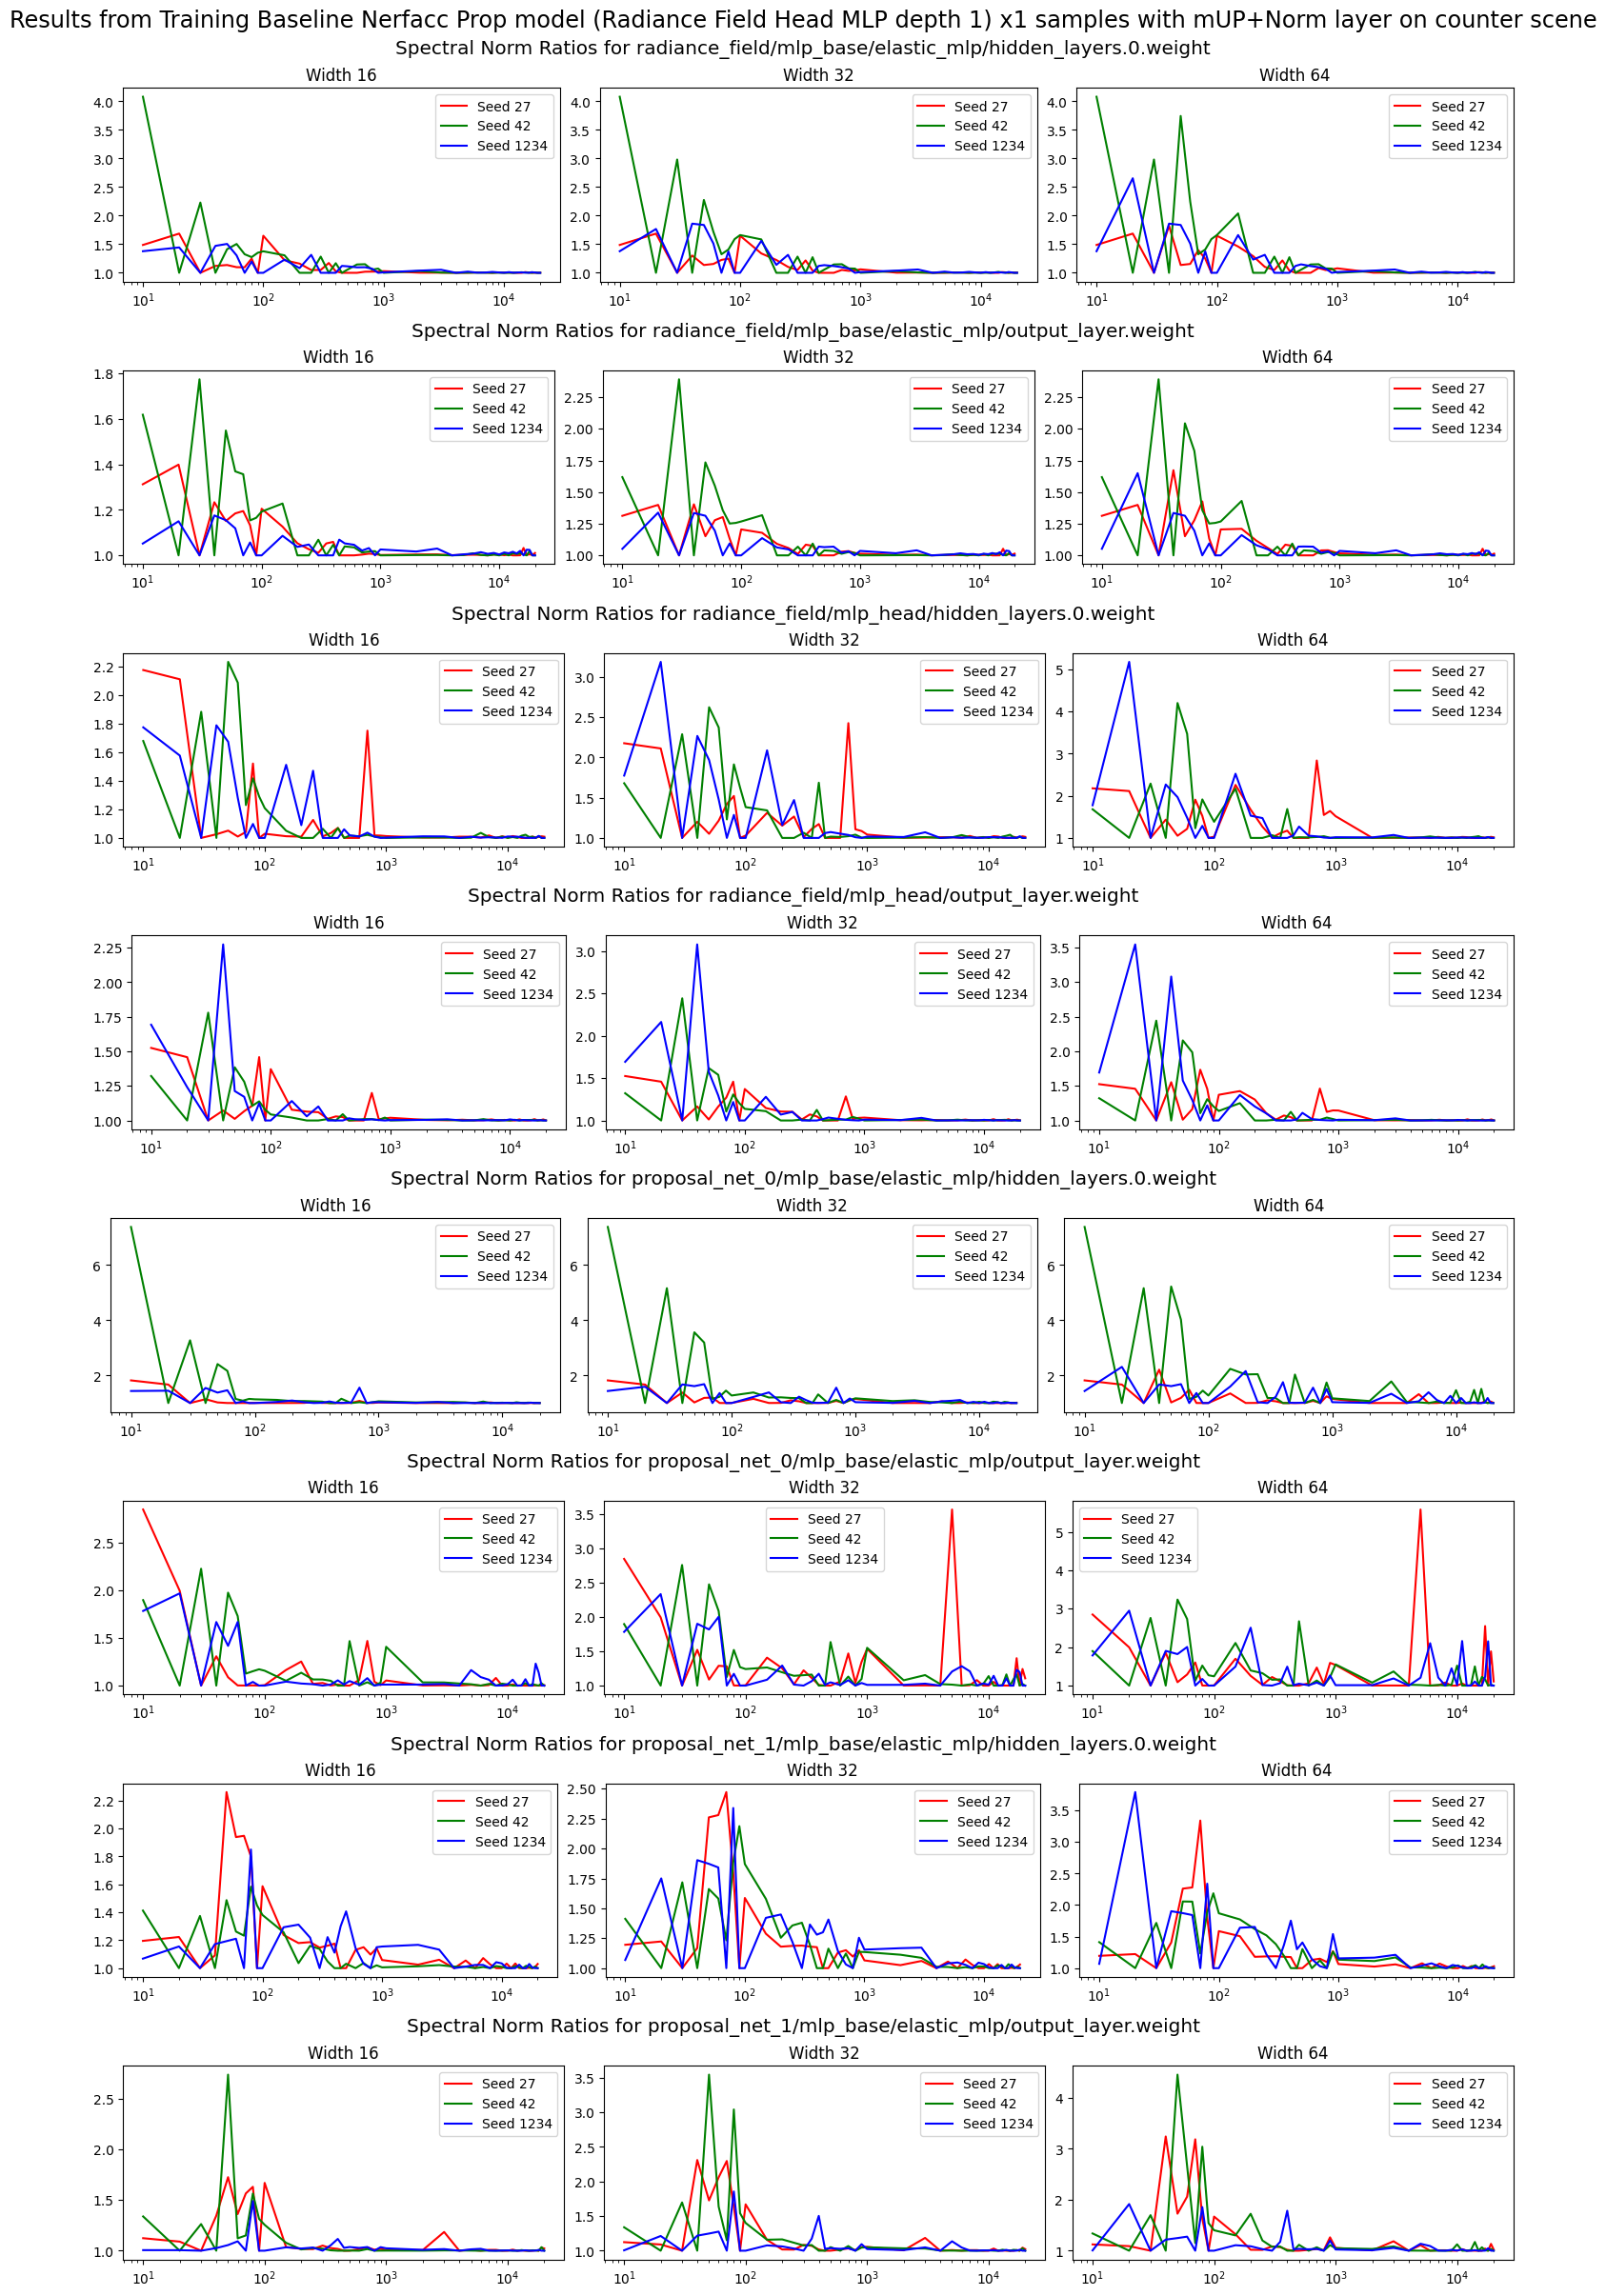

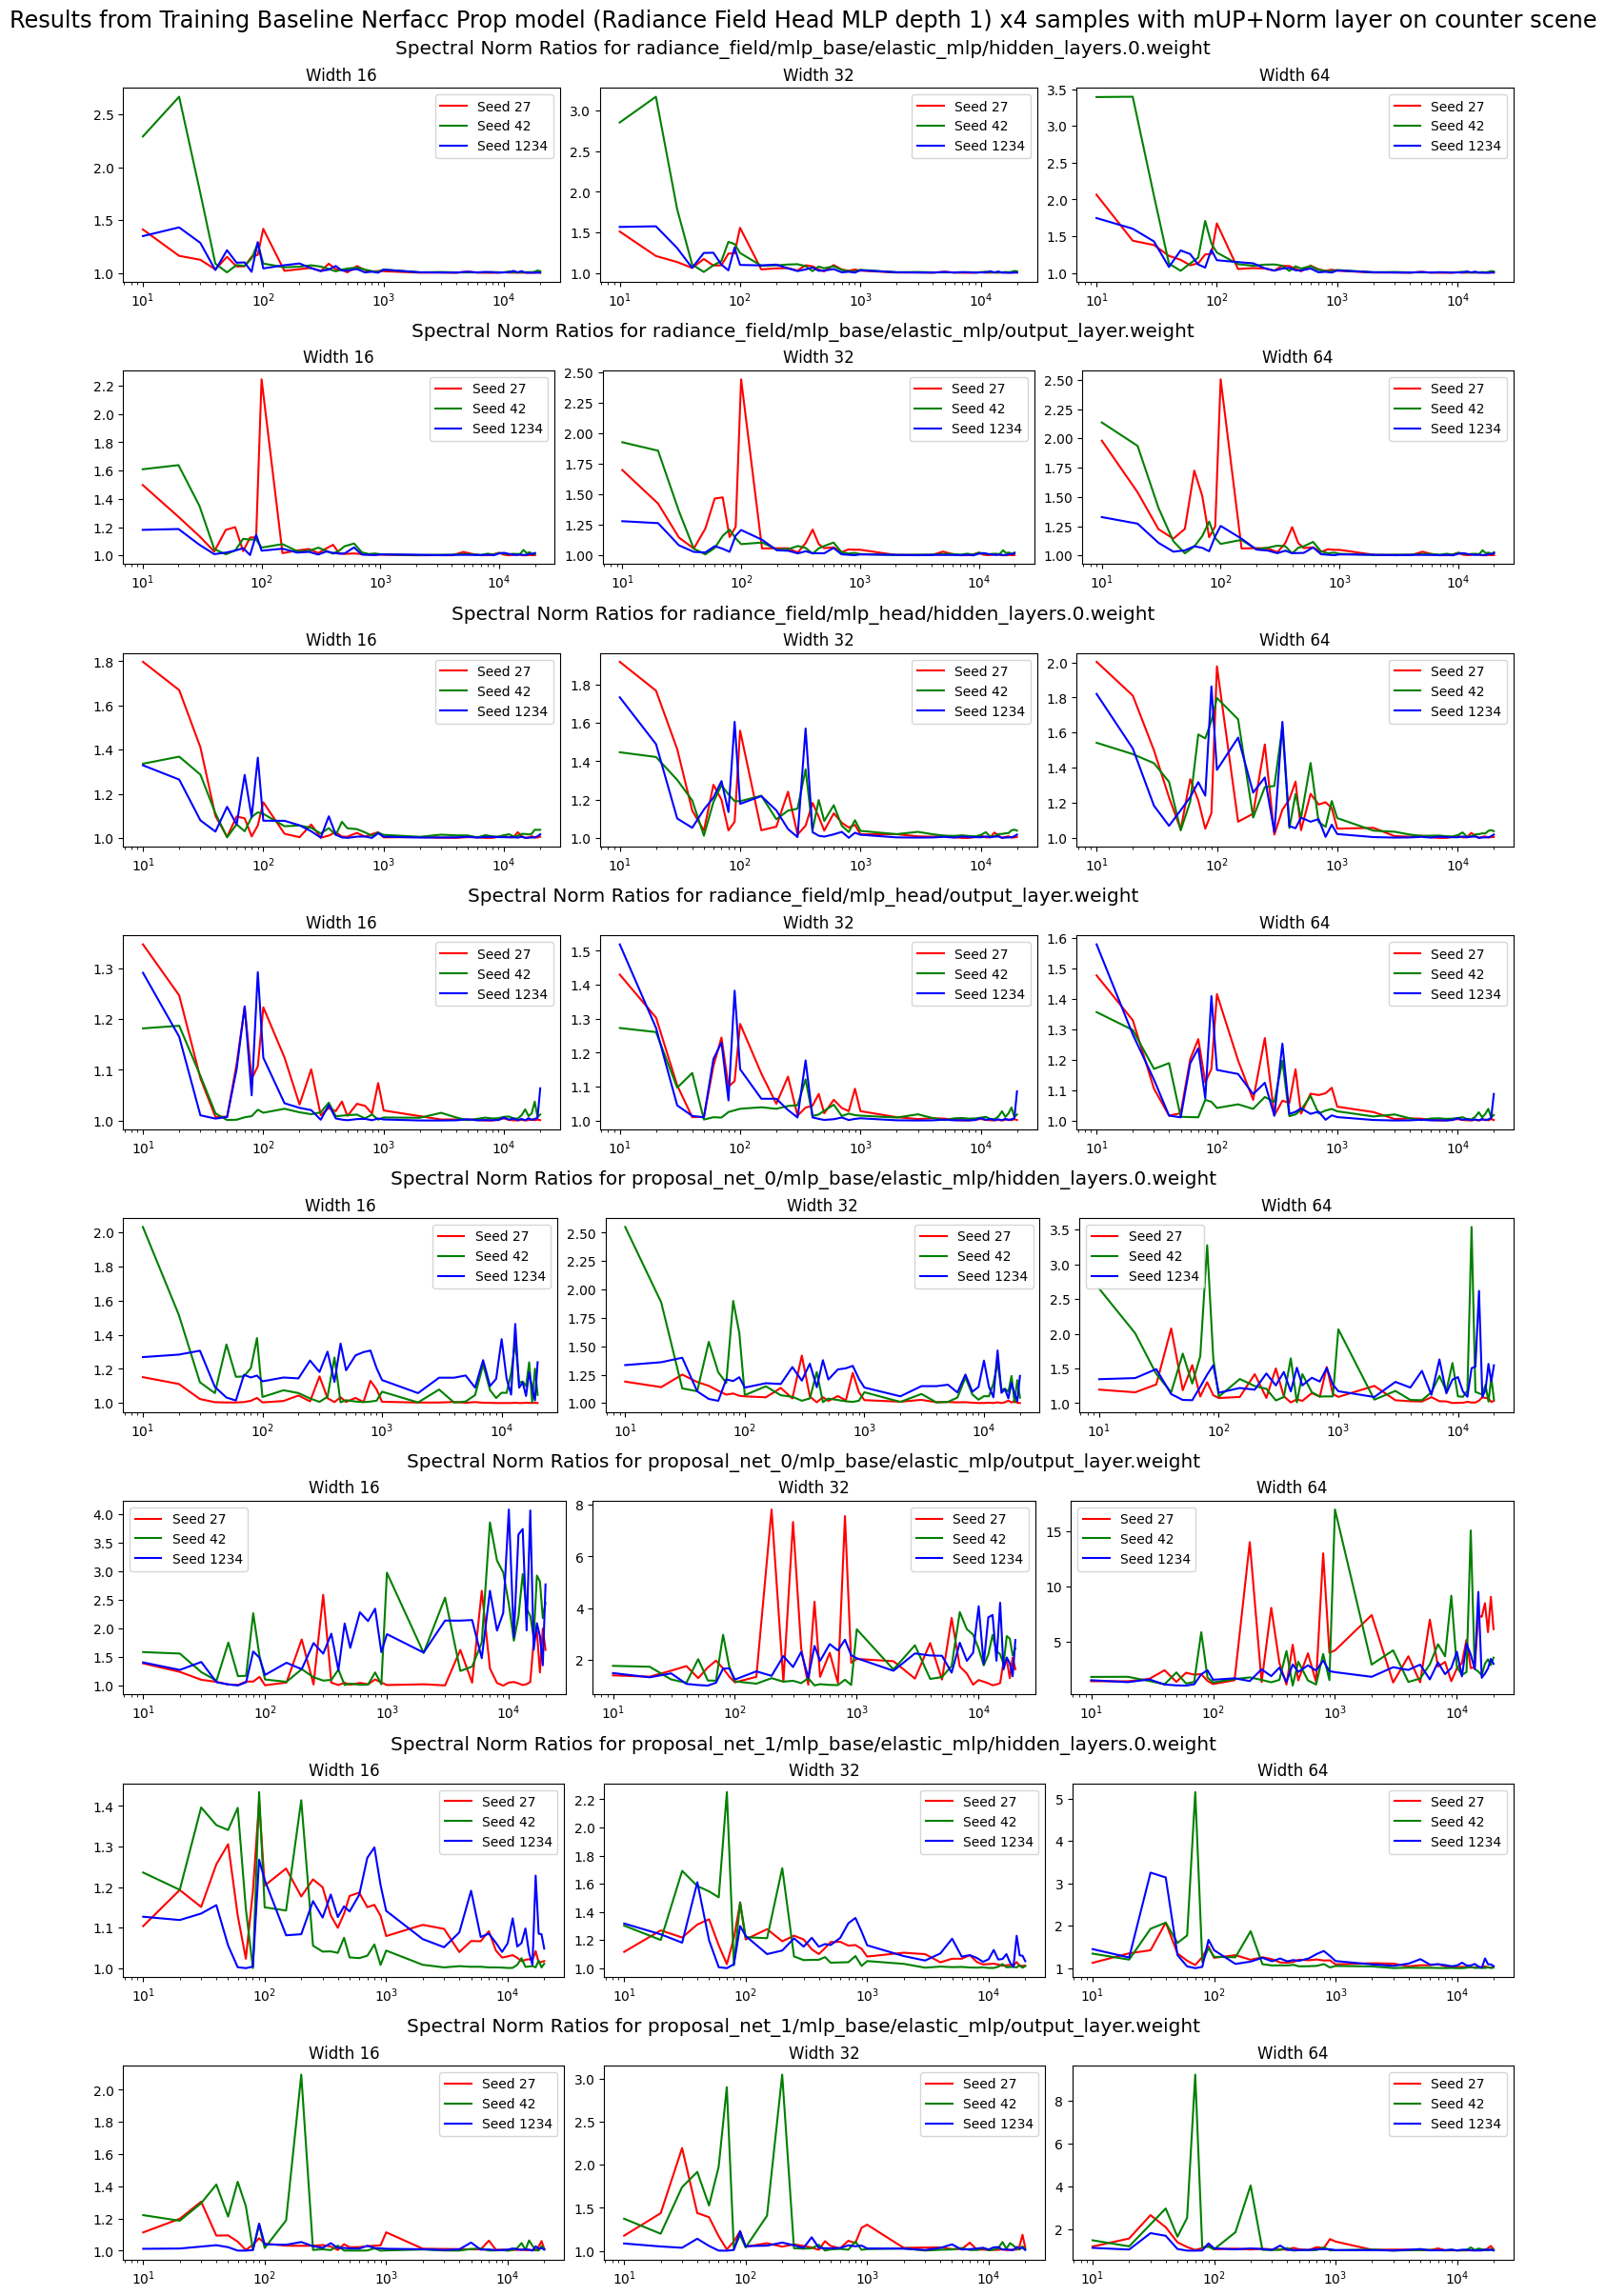

In [ ]:
metric_type = "grad/Spectral (max)"
elastic_widths = [8,16,32,64]

for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for widths_to_sample, widths_to_sample_group in model_type_group.groupby(
                by="num_widths_to_sample"
            ):
            for head_depth, head_depth_group in widths_to_sample_group.groupby(
                by="radiance_field.head_depth"
            ):
                num_modules = 0
                filtered_modules = []
                for m in head_depth_group["module"].unique():
                    if 'norm' not in m:
                        filtered_modules.append(m)
                        num_modules += 1
                fig = plt.figure(
                    layout="constrained",
                    figsize=(
                        5 * (len(elastic_widths)-1),
                        3 * num_modules,
                    ),
                )
                model_type_name = (
                    "Nerfacc Occ" if "occ" in model_type else "Nerfacc Prop"
                )
                fig.suptitle(
                    f"Results from Training Baseline {model_type_name} model (Radiance Field Head MLP depth {head_depth}) x{widths_to_sample} samples with mUP+Norm layer on {scene} scene",
                    fontsize="xx-large",
                )
                colors = ["r", "g", "b"]
                subfigs = fig.subfigures(
                    num_modules, 1, wspace=0.07
                )
                for i, module in enumerate(filtered_modules):
                    module_group = head_depth_group.query('module == @module')
                    subfig = subfigs[i]
                    subfig.suptitle(
                        f"Spectral Norm Ratios for {module}", fontsize="x-large"
                    )
                    subplots = subfig.subplots(1, len(elastic_widths)-1)
                    for j, elastic_width in enumerate(elastic_widths):
                        if elastic_width == 8:
                            # Skip width 8 since we're plotting the ratio wrt it (so it'll be constant).
                            continue
                        ax = subplots[j-1]
                        base_psnrs = module_group.query("width == 8")
                        for k, (seed, seed_group) in enumerate(
                            module_group.query('width == @elastic_width').groupby(by="seed")
                        ):
                            base_psnrs_over_steps = base_psnrs.query('seed == @seed')
                            assert(len(base_psnrs_over_steps) == len(seed_group))
                            assert(len(seed_group) != 0)
                            with np.errstate(divide='ignore',invalid='ignore'):
                                out = np.divide(
                                        seed_group[f"{metric_type}"].to_numpy(),
                                        base_psnrs_over_steps[f"{metric_type}"].to_numpy(),
                                    )
                            ax.plot(
                                width_group["step"],
                                out,
                                color=colors[k],
                                label=f"Seed {seed}",
                            )
                        ax.set_xscale("log")
                        ax.set_title(f"Width {elastic_width}")
                        ax.legend()
                fig.show()
    # Only plot 1 scene
    break

# Relative Change in Spectral Norm between initial and final


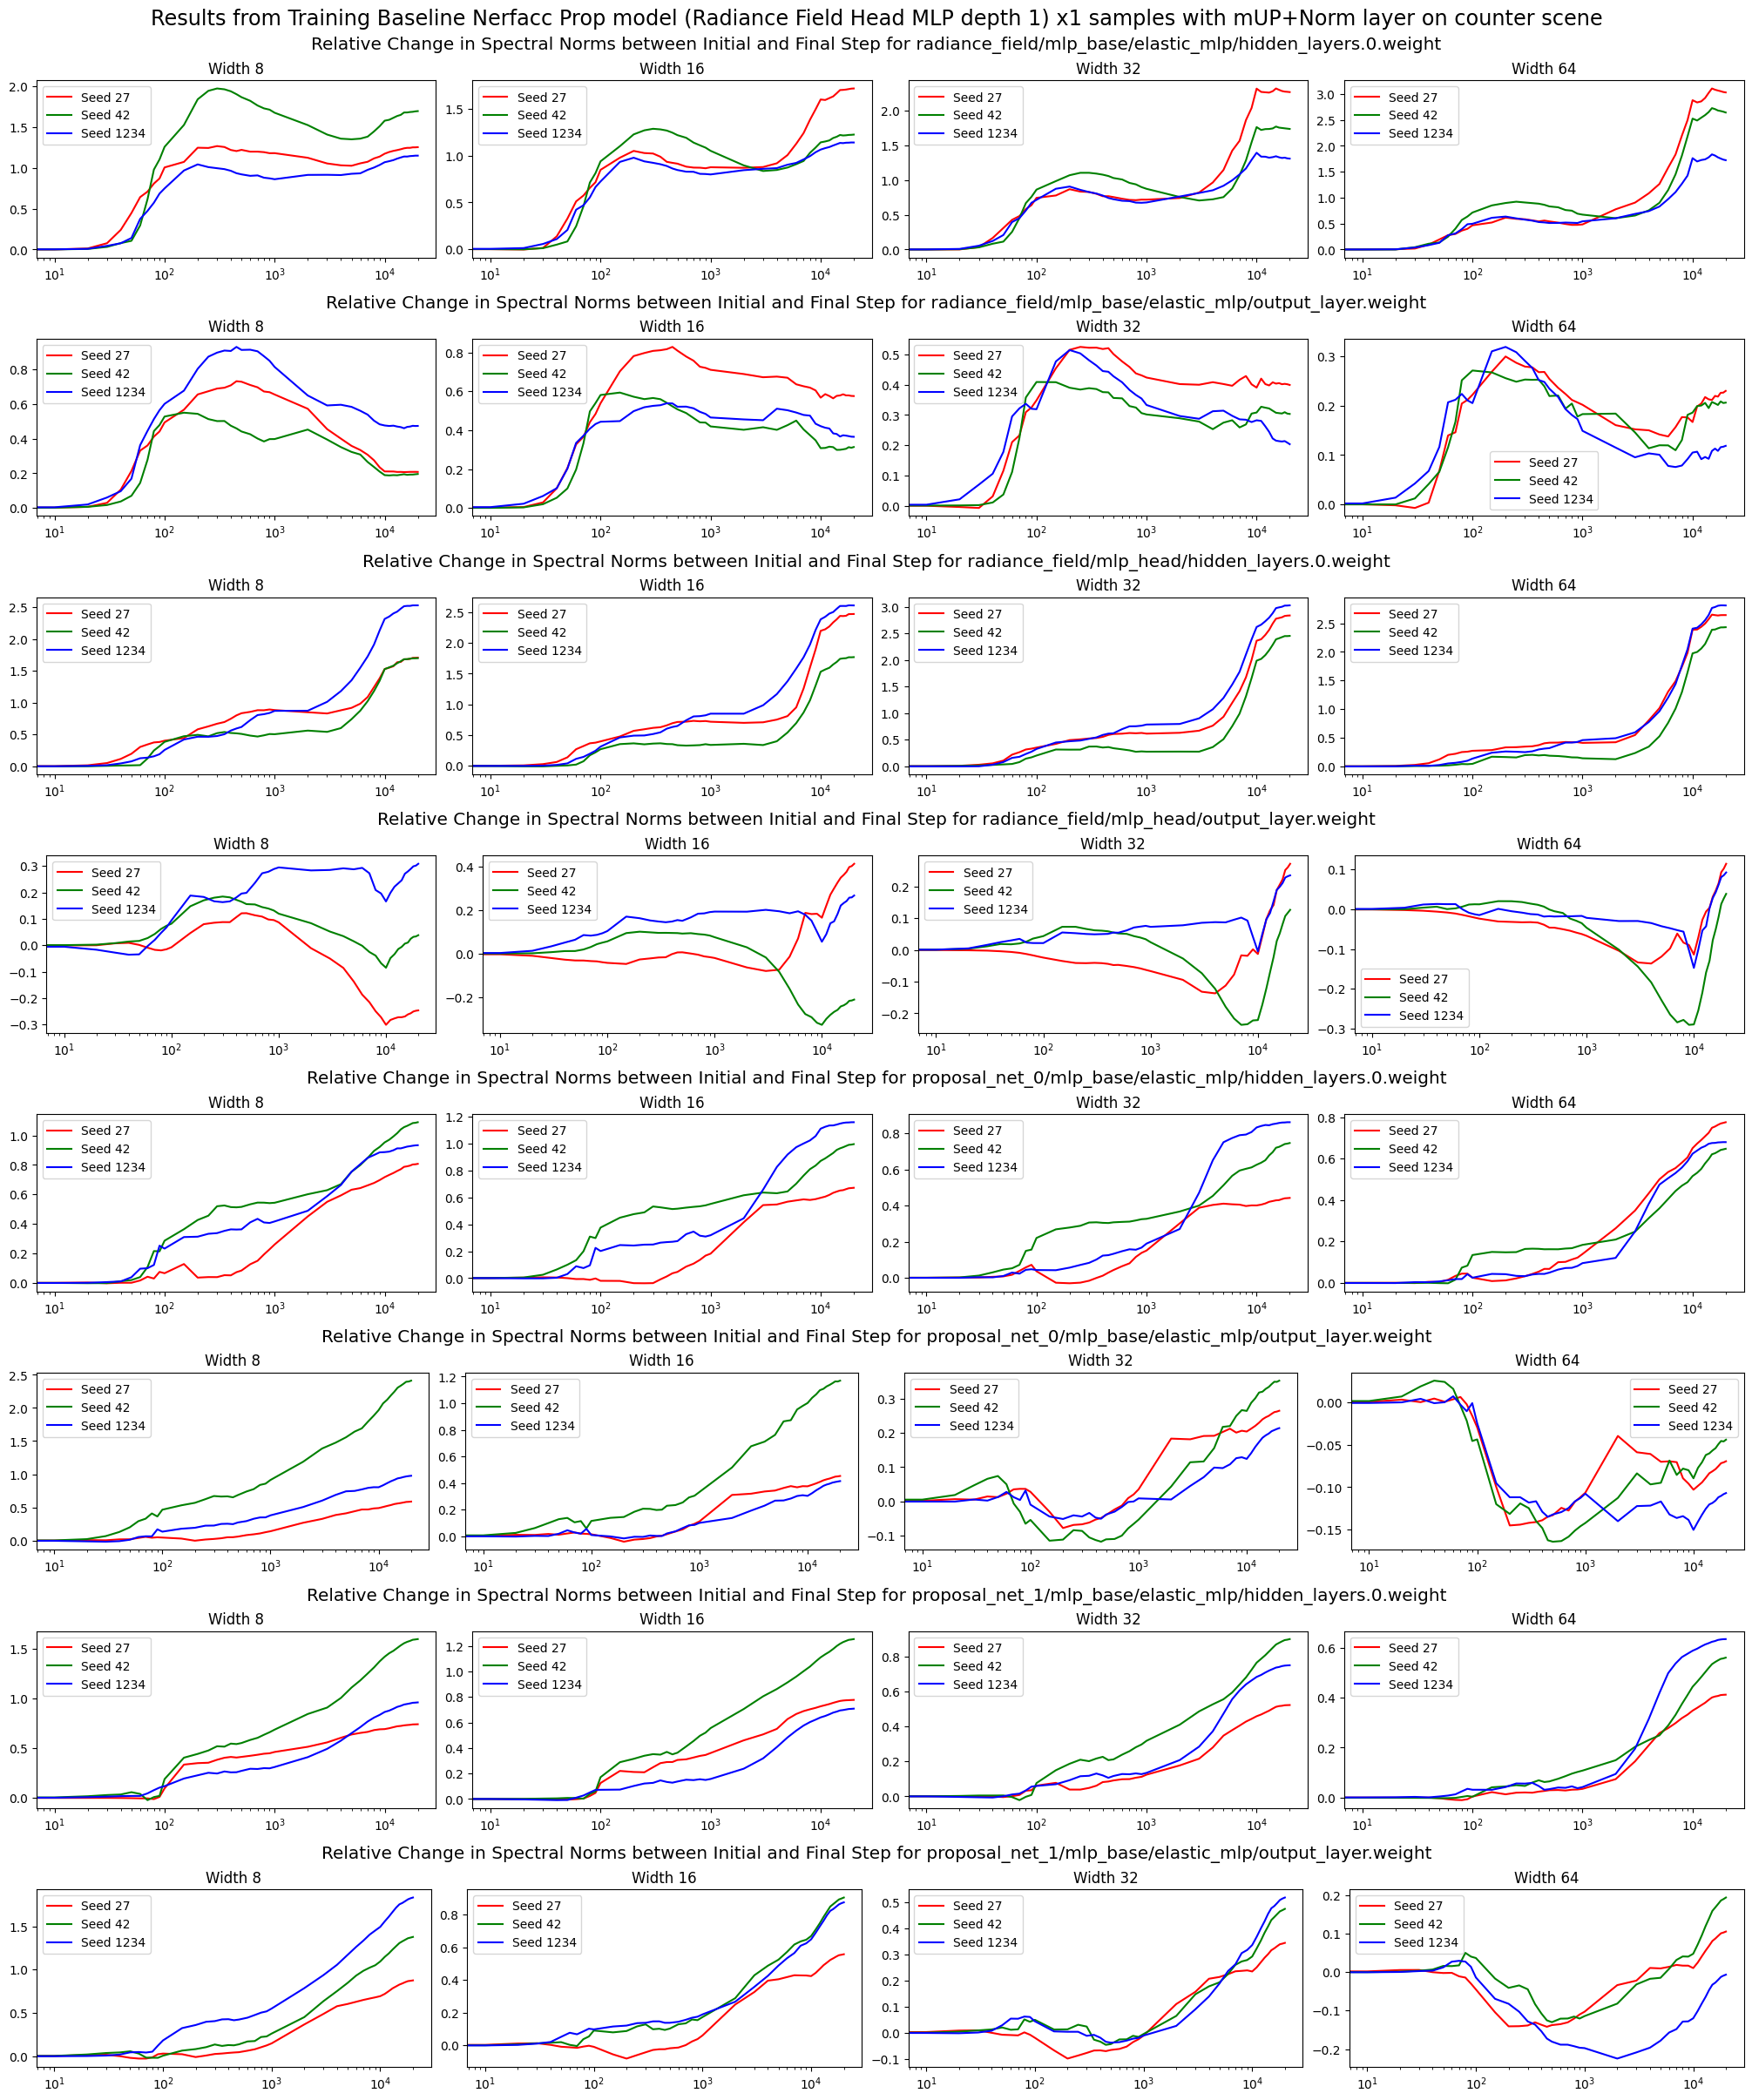

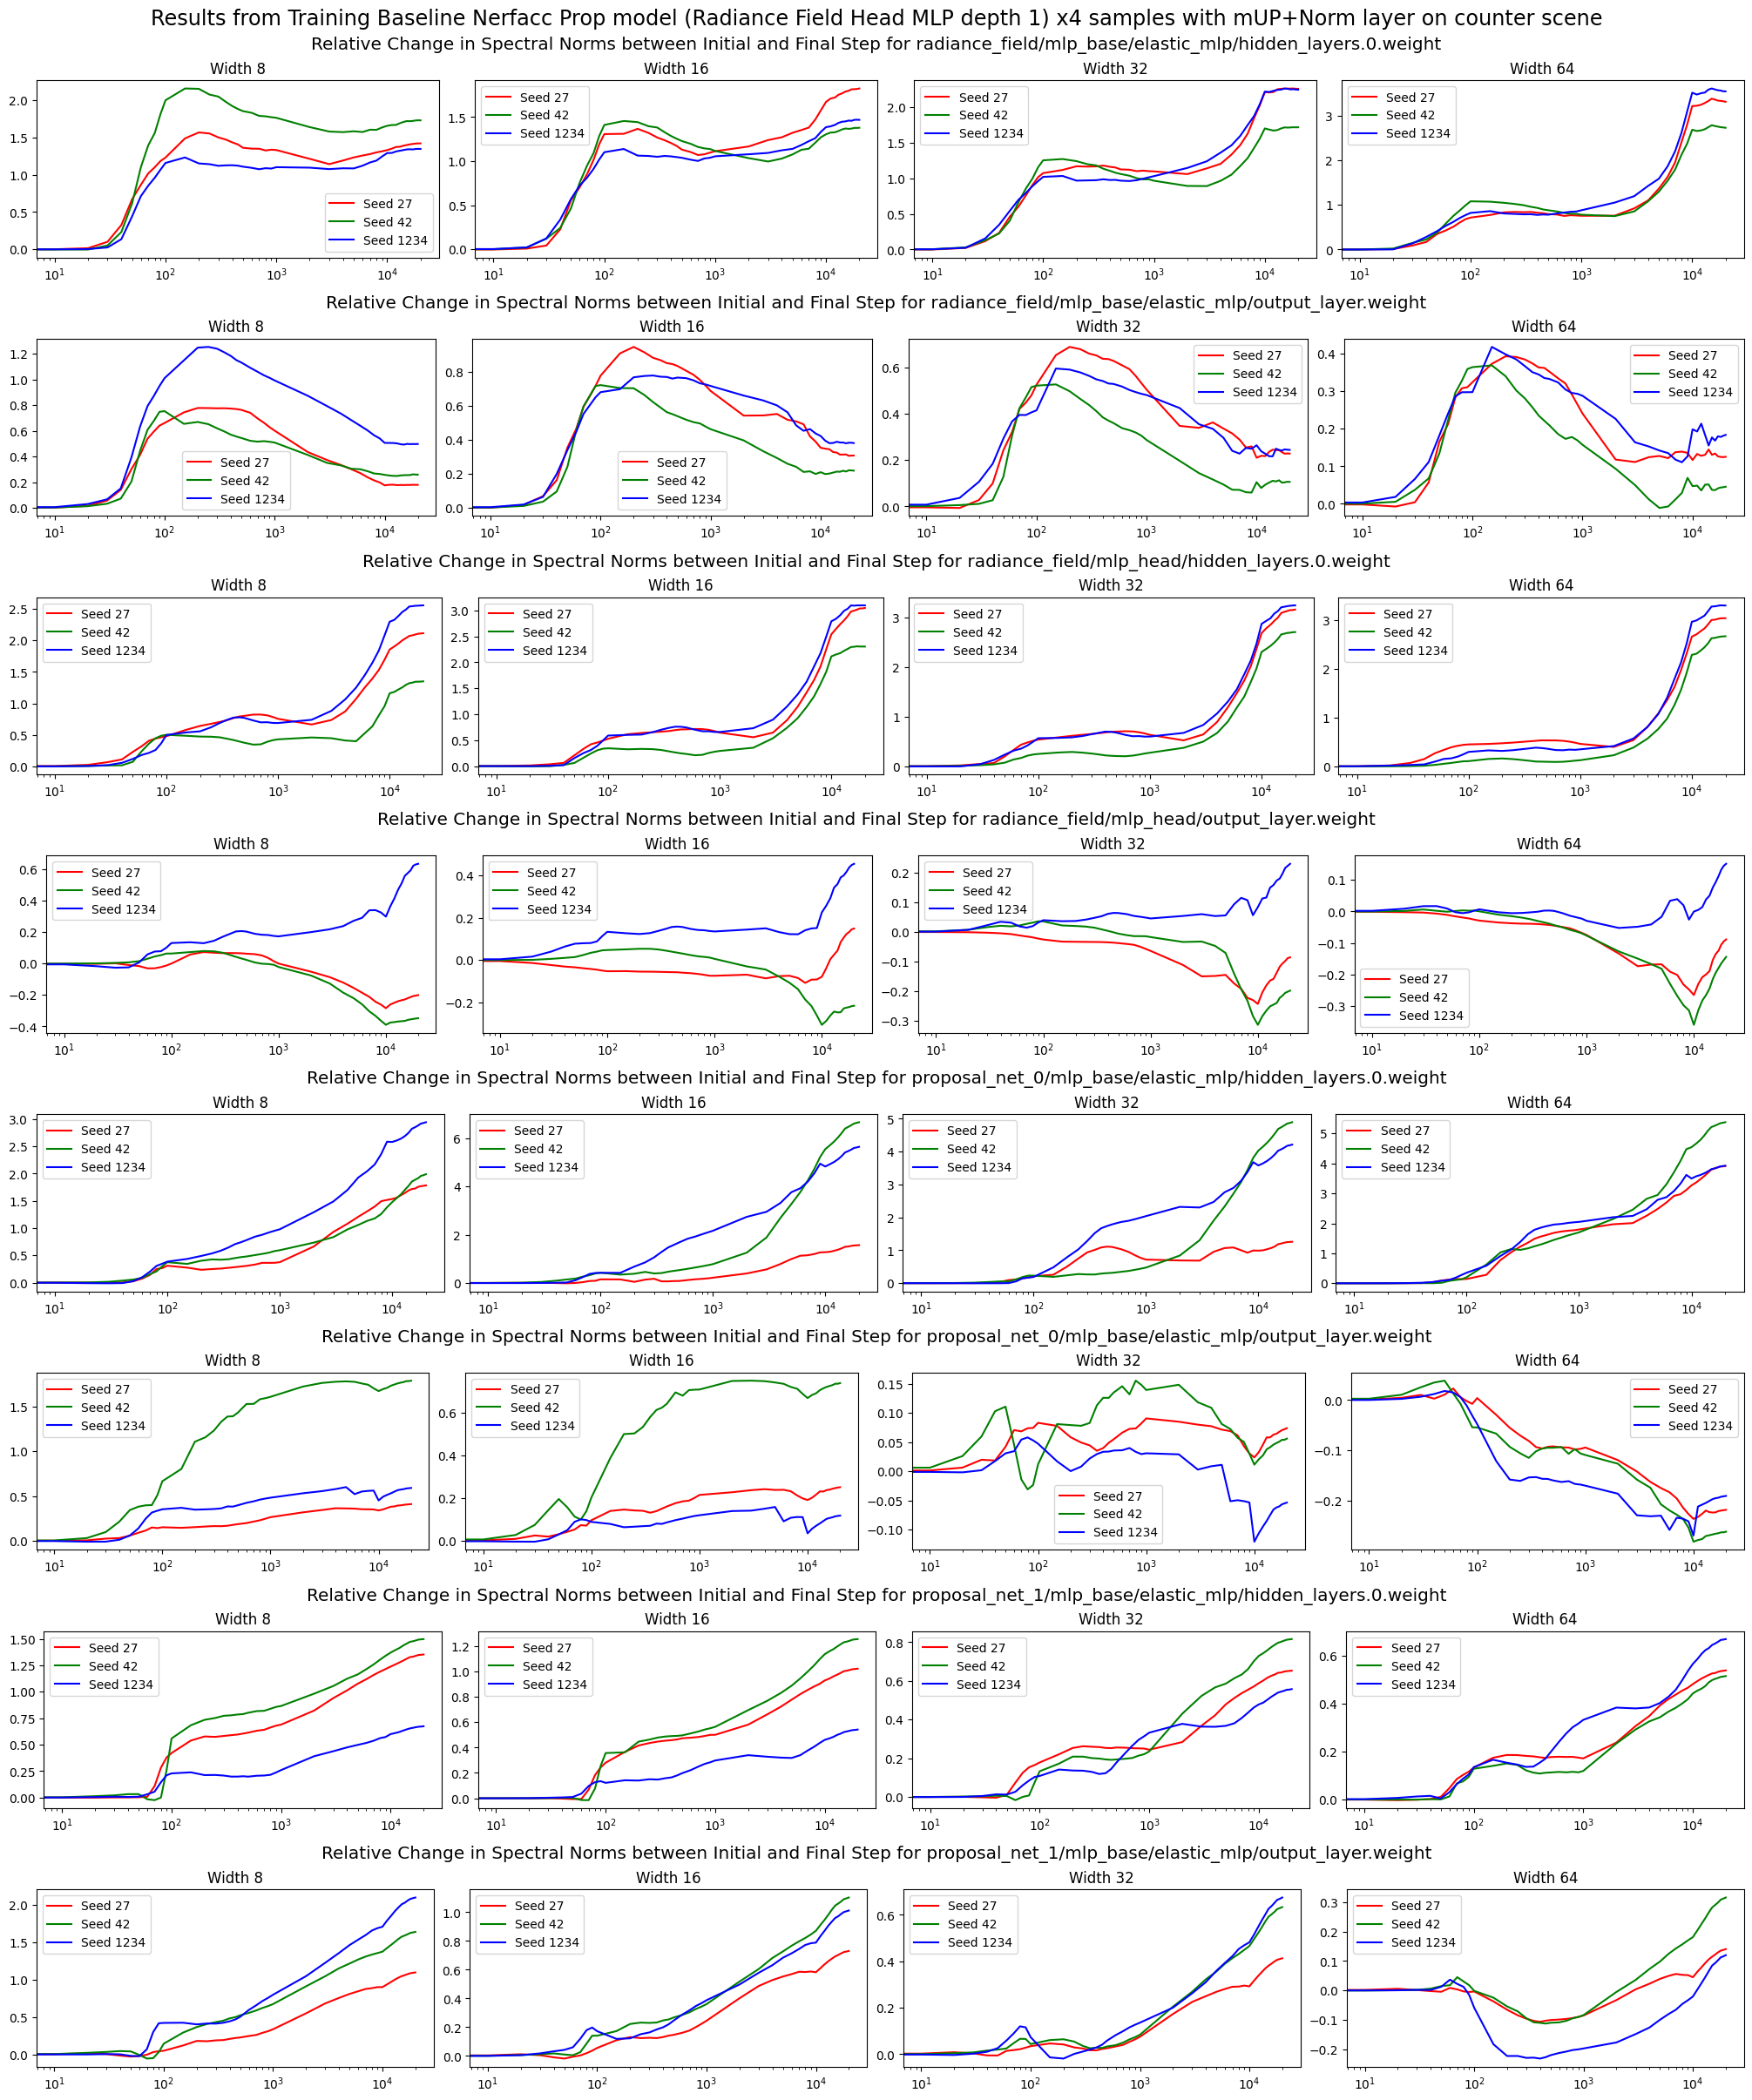

In [ ]:
metric_type = "weight/Spectral (max)"
elastic_widths = [8,16,32,64]

for scene, scene_group in df.groupby(by="dataset.scene"):
    for model_type, model_type_group in scene_group.groupby(by="model_type"):
        for widths_to_sample, widths_to_sample_group in model_type_group.groupby(
                by="num_widths_to_sample"
            ):
            for head_depth, head_depth_group in widths_to_sample_group.groupby(
                by="radiance_field.head_depth"
            ):
                num_modules = 0
                filtered_modules = []
                for m in head_depth_group["module"].unique():
                    if 'norm' not in m:
                        filtered_modules.append(m)
                        num_modules += 1
                fig = plt.figure(
                    layout="constrained",
                    figsize=(
                        5 * (len(elastic_widths)),
                        3 * num_modules,
                    ),
                )
                model_type_name = (
                    "Nerfacc Occ" if "occ" in model_type else "Nerfacc Prop"
                )
                fig.suptitle(
                    f"Results from Training Baseline {model_type_name} model (Radiance Field Head MLP depth {head_depth}) x{widths_to_sample} samples with mUP+Norm layer on {scene} scene",
                    fontsize="xx-large",
                )
                colors = ["r", "g", "b"]
                subfigs = fig.subfigures(
                    num_modules, 1, wspace=0.07
                )
                for i, module in enumerate(filtered_modules):
                    module_group = head_depth_group.query('module == @module')
                    subfig = subfigs[i]
                    subfig.suptitle(
                        f"Relative Change in Spectral Norms between Initial and Final Step for {module}", fontsize="x-large"
                    )
                    subplots = subfig.subplots(1, len(elastic_widths))
                    for j, elastic_width in enumerate(elastic_widths):
                        ax = subplots[j]
                        base_psnrs = module_group.query("width == @elastic_width and step == 0")
                        for k, (seed, seed_group) in enumerate(
                            module_group.query('width == @elastic_width').groupby(by="seed")
                        ):
                            base_psnr_step0 = base_psnrs.query('seed == @seed')[f"{metric_type}"]
                            assert(len(seed_group) != 0)
                            assert(len(base_psnr_step0) == 1)
                            out = (seed_group[f"{metric_type}"].to_numpy() - base_psnr_step0.iloc[0]) / base_psnr_step0.iloc[0]
                            ax.plot(
                                width_group["step"],
                                out,
                                color=colors[k],
                                label=f"Seed {seed}",
                            )
                        ax.set_xscale("log")
                        ax.set_title(f"Width {elastic_width}")
                        ax.legend()
                fig.show()
    # Only plot 1 scene
    break